🧬 NSCLC RADIOGENOMIC ML ANALYSIS

🚀 INITIALIZING MAIN PIPELINE WITH ENGINEERED FEATURES

🤖 RECURRENCE PREDICTION ON ENGINEERED FEATURES
------------------------------------------------------------
SVM                    | CV Mean AUC: 0.6249 | Test AUC: 0.3989
Logistic Regression    | CV Mean AUC: 0.6351 | Test AUC: 0.4654
Naive Bayes            | CV Mean AUC: 0.6170 | Test AUC: 0.4840


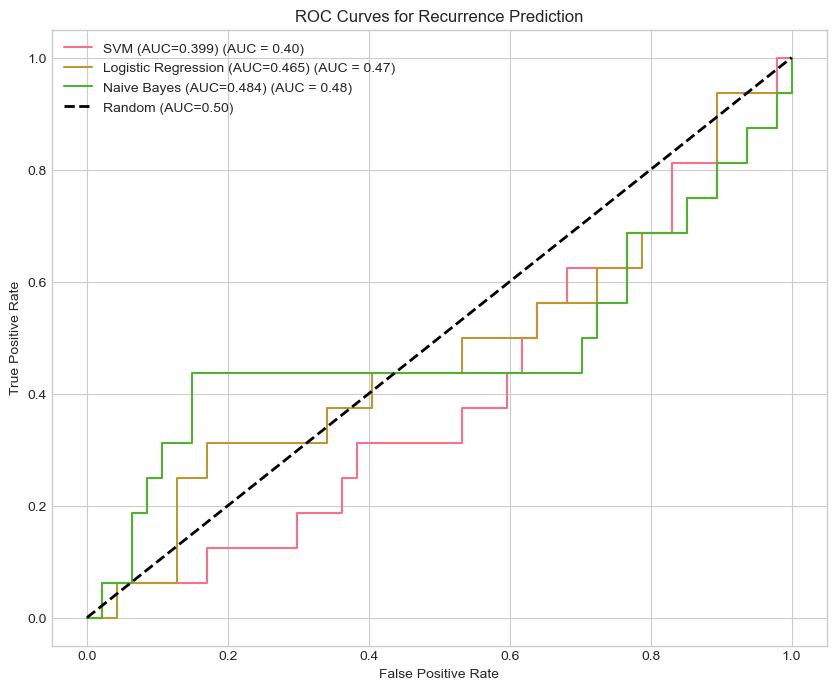


✅ Saved ROC AUC plot for Recurrence prediction.

❌ Skipping survival analysis: required columns not found.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional
import random
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Survival Analysis (if available)
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test
    SURVIVAL_AVAILABLE = True
except ImportError:
    print("⚠️  Lifelines not installed. Survival analysis will be skipped.")
    print("   Install with: pip install lifelines")
    SURVIVAL_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "").str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    if status == "Current":
        return 3
    if status == "Former":
        return 1
    return 0

def load_and_explore_data(file_path: Path) -> Optional[pd.DataFrame]:
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return None
    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    df_eng = df.copy()
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = df_eng["Age at Histological Diagnosis"]
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")

    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left  = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    def checked_to_int(series):
        return (series == "Checked").astype(int)
    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)

    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v in ["Wildtype"] else np.nan)
            )
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)

    t_cols = ["Chemotherapy", "Radiation", "Adjuvant Treatment"]
    df_eng["Treatment_Count"] = 0
    for t in t_cols:
        if t in df_eng.columns:
            df_eng["Treatment_Count"] += (df_eng[t] == "Yes").astype(int)
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)

    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)

    if "Days between CT and surgery" in df_eng.columns:
        days = df_eng["Days between CT and surgery"]
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)
    
    NUMERIC_LIKE_TEXT = ["Weight (lbs)", "Pack Years", "%GG"]
    df_eng = _coerce_numeric(df_eng, NUMERIC_LIKE_TEXT)

    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    if "Recurrence" in df_eng:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    if "EGFR mutation status" in df_eng:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )
    return df_eng

# =============================================================================
# 3) COMPREHENSIVE MACHINE LEARNING PIPELINE
# =============================================================================

class NSCLCMLPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        # Using a focused list of three classifiers
        self.models = {
            'SVM': SVC(probability=True, random_state=42, kernel='rbf', class_weight='balanced'),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}
        self.feature_names_: Dict[str, List[str]] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        """
        Selects all valid feature columns from the dataframe provided during initialization.
        """
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])
        
        candidates = [
            col for col in self.df.columns 
            if pd.api.types.is_numeric_dtype(self.df[col]) and col not in exclude_cols
        ]
        
        if not candidates:
            return pd.DataFrame(index=self.df.index), []
        
        X = self.df[candidates].copy()
        
        X.dropna(axis=1, how='all', inplace=True)
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
            
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed_arr, columns=X.columns, index=X.index)

        return X_imputed, list(X.columns)

    def _prepare_target(self, target_col: str) -> pd.Series:
        return self.df[target_col].copy()

    def evaluate_models(self, target_col: str, task_name: str):
        print(f"\n🤖 {task_name.upper()} PREDICTION ON ENGINEERED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            return {}
        y = self._prepare_target(target_col)
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        if X.shape[1] == 0:
            return {}

        class_counts = y.value_counts()
        if len(class_counts) < 2: return {}
        min_class = class_counts.min()
        if min_class < 2: return {}
        n_splits = max(2, min(5, int(min_class)))

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for name, model in self.models.items():
            try:
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)

                print(f"{name:<22} | CV Mean AUC: {np.mean(cv_scores):.4f} | Test AUC: {auc_score:.4f}")

                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model, 'Scaler': scaler, 'y_test': y_test, 'y_prob': y_prob,
                    'Feature_Names': feat_names, 'X_test': X_test
                }
            except Exception:
                pass
        self.results[task_name] = task_results
        self.feature_names_[task_name] = feat_names
        return task_results
    
    def get_feature_importance(self, task_name: str, top_k: int = 10) -> pd.DataFrame:
        if task_name not in self.results or not self.results[task_name]:
            return pd.DataFrame()
        best_model_name = max(
            self.results[task_name].keys(),
            key=lambda k: self.results[task_name][k]['Test_AUC']
        )
        best = self.results[task_name][best_model_name]
        model = best['Model']
        names = best['Feature_Names']
        if hasattr(model, 'feature_importances_'):
            scores = model.feature_importances_
        elif hasattr(model, 'coef_'):
            coef = model.coef_
            scores = np.abs(coef[0]) if coef.ndim == 2 else np.abs(coef)
        else:
            # Naive Bayes has neither feature_importances_ nor coef_
            return pd.DataFrame()
        imp = (pd.DataFrame({'feature': names, 'importance': scores})
               .sort_values('importance', ascending=False)
               .head(top_k)
               .reset_index(drop=True))
        imp['Model'] = best_model_name
        return imp

def plot_recurrence_roc_auc(pipe: NSCLCMLPipeline):
    if "Recurrence" not in pipe.results or not pipe.results["Recurrence"]:
        print("\n❌ Recurrence results not found, skipping ROC plot.")
        return

    task_results = pipe.results["Recurrence"]
    plt.figure(figsize=(10, 8))
    
    for name, result_dict in task_results.items():
        RocCurveDisplay.from_predictions(
            result_dict['y_test'],
            result_dict['y_prob'],
            name=f"{name} (AUC={result_dict['Test_AUC']:.3f})",
            ax=plt.gca()
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.50)')
    plt.title('ROC Curves for Recurrence Prediction')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.savefig('recurrence_roc_auc_curve.png')
    plt.show()
    print("\n✅ Saved ROC AUC plot for Recurrence prediction.")

def perform_survival_analysis(df: pd.DataFrame):
    if not SURVIVAL_AVAILABLE:
        print("\n⚠️  Survival analysis skipped due to missing `lifelines` library.")
        return

    print("\n📈 PERFORMING SURVIVAL ANALYSIS")
    print("-" * 60)
    
    survival_df = df.copy()
    
    survival_df = survival_df[
        (survival_df['Recurrence'].isin(['yes', 'no'])) & 
        (pd.to_numeric(survival_df.get('Time to Recurrence (days)'), errors='coerce').notna())
    ]
    
    if survival_df.empty:
        print("   ❌ No valid data for survival analysis after cleaning.")
        return

    survival_df['Recurrence_Event'] = (survival_df['Recurrence'] == 'yes').astype(int)
    survival_df['Time_to_Recurrence'] = pd.to_numeric(survival_df['Time to Recurrence (days)'], errors='coerce')
    survival_df = survival_df.dropna(subset=['Time_to_Recurrence'])

    if len(survival_df['Recurrence_Event'].unique()) < 2:
        print("   ⚠️  Only one group present after cleaning. Cannot perform log-rank test.")
        return

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    for name, grouped_df in survival_df.groupby('Recurrence_Event'):
        label = 'Recurrence' if name == 1 else 'No Recurrence'
        kmf.fit(grouped_df['Time_to_Recurrence'], event_observed=grouped_df['Recurrence_Event'], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=False)
        
    plt.title('Kaplan-Meier Survival Curve by Recurrence Status')
    plt.xlabel('Time to Recurrence (days)')
    plt.ylabel('Probability of No Recurrence')
    plt.grid(True)
    plt.legend(loc='best')
    plt.savefig('recurrence_survival_curve.png')
    plt.show()
    print("✅ Saved Kaplan-Meier Survival Curve.")

    T1 = survival_df[survival_df['Recurrence_Event'] == 1]['Time_to_Recurrence']
    E1 = survival_df[survival_df['Recurrence_Event'] == 1]['Recurrence_Event']
    T0 = survival_df[survival_df['Recurrence_Event'] == 0]['Time_to_Recurrence']
    E0 = survival_df[survival_df['Recurrence_Event'] == 0]['Recurrence_Event']

    results = logrank_test(T1, T0, E1, E0)
    print(f"\nLog-rank test p-value: {results.p_value:.4f}")

def main():
    DEFAULT_PATH = Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv")
    df = load_and_explore_data(DEFAULT_PATH)
    if df is None: return
    print("🧬 NSCLC RADIOGENOMIC ML ANALYSIS")
    print("=" * 65)

    df_eng = engineer_clinical_features(df)
    
    # --- Simplified Workflow ---
    print("\n🚀 INITIALIZING MAIN PIPELINE WITH ENGINEERED FEATURES")
    pipe = NSCLCMLPipeline(df_eng)
    
    tasks = [("Recurrence_Binary", "Recurrence")]
    for target_col, task_name in tasks:
        if target_col in df_eng.columns:
            res = pipe.evaluate_models(target_col, task_name)
            if res:
                fi = pipe.get_feature_importance(task_name, top_k=10)
                if not fi.empty:
                    print("\n🔎 Top features (by best model):")
                    print(fi.to_string(index=False))
        else:
            print(f"\n❌ Skipping {task_name} (target column missing).")
    
    if "Recurrence" in pipe.results:
        plot_recurrence_roc_auc(pipe)
    
    if all(c in df_eng.columns for c in ["Recurrence", "Time to Recurrence (days)"]):
        perform_survival_analysis(df_eng)
    else:
        print("\n❌ Skipping survival analysis: required columns not found.")

if __name__ == "__main__":
    main()

📅 Run at: 2025-08-27 18:46:51
✅ Loaded dataset: 211 patients, 40 features

🧬 NSCLC RADIOGENOMIC ML ANALYSIS

🚀 INITIALIZING MAIN PIPELINE WITH ENGINEERED FEATURES

🤖 RECURRENCE PREDICTION ON ENGINEERED FEATURES
------------------------------------------------------------
SVM                    | CV Mean AUC: 0.6152 | Test AUC: 0.3963
Logistic Regression    | CV Mean AUC: 0.6364 | Test AUC: 0.4707
Naive Bayes            | CV Mean AUC: 0.6170 | Test AUC: 0.4840


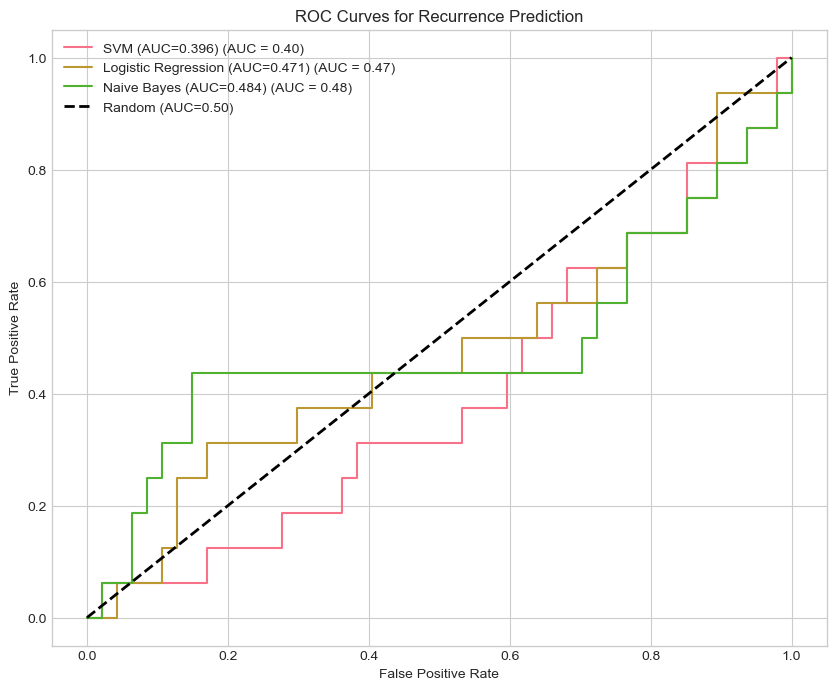

✅ Saved ROC AUC plot for Recurrence prediction.

📊 SHAP analysis for Recurrence — Best model: Naive Bayes
   Train shape: (147, 23) | Test shape: (63, 23)
   Using KernelExplainer (SVM / GaussianNB).


  0%|          | 0/60 [00:00<?, ?it/s]

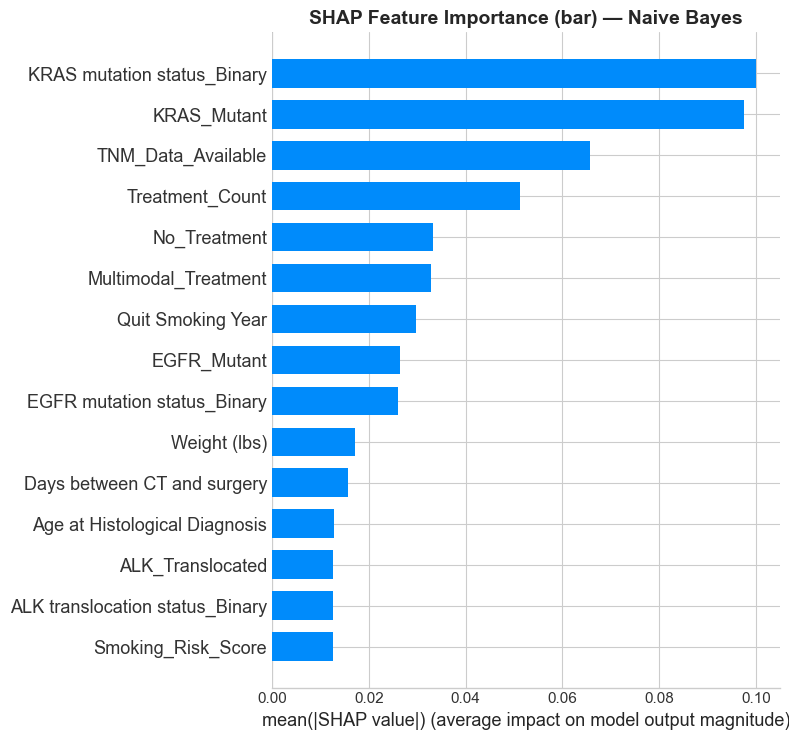

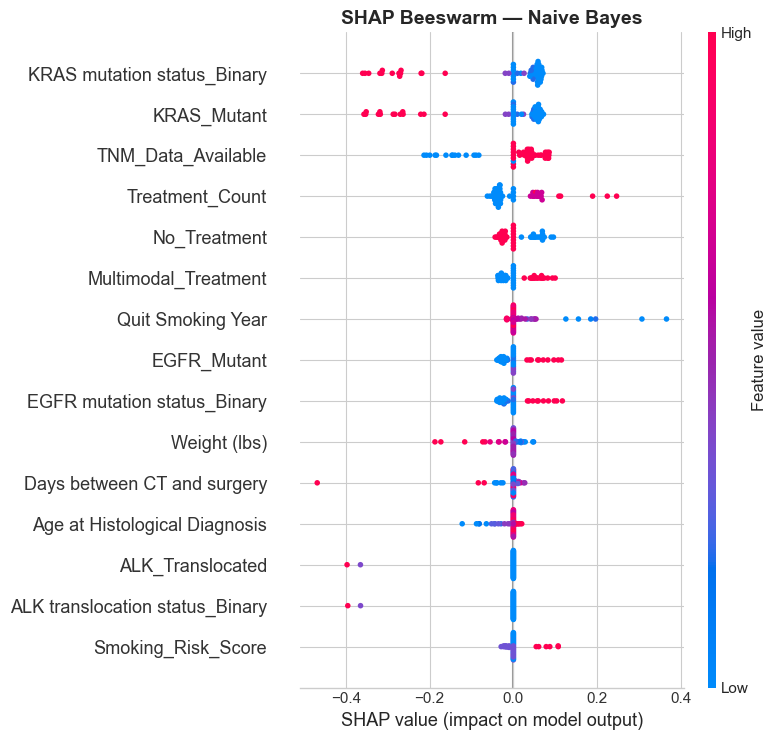

✅ SHAP plots saved: shap_summary_bar.png, shap_beeswarm.png

📈 Kaplan–Meier: Time to Death
❌ Not enough variation for survival analysis.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Optional survival analysis
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    SURVIVAL_AVAILABLE = True
except ImportError:
    SURVIVAL_AVAILABLE = False

# Optional SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

DEFAULT_PATHS = [
    Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv"),
    Path("/mnt/data/NSCLCR01Radiogenomic_.csv"),
]

def _find_existing_path(paths: List[Path]) -> Optional[Path]:
    for p in paths:
        if p.exists():
            return p
    return None

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "", regex=False).str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    if status == "Current":
        return 3
    if status == "Former":
        return 1
    return 0

# -----------------------------------------------------------------------------
# Data loading & feature engineering
# -----------------------------------------------------------------------------

def load_and_explore_data(file_path: Optional[Path] = None) -> Optional[pd.DataFrame]:
    if file_path is None:
        file_path = _find_existing_path(DEFAULT_PATHS)
    if file_path is None:
        print("❌ Dataset not found in expected paths.")
        return None

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ Dataset not found at {file_path}")
        return None

    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])

    print(f"✅ Loaded dataset: {df.shape[0]} patients, {df.shape[1]} features")
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    df_eng = df.copy()

    # Age features
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = pd.to_numeric(df_eng["Age at Histological Diagnosis"], errors="coerce")
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2

    # Smoking features
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")

    # Tumor location features (checkbox columns)
    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left  = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    def checked_to_int(series): return (series == "Checked").astype(int)

    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)

    # Mutation features
    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v == "Wildtype" else np.nan)
            )
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)

    # Treatment features
    for t in ["Chemotherapy", "Radiation", "Adjuvant Treatment"]:
        if t not in df_eng.columns:
            df_eng[t] = np.nan
    df_eng["Treatment_Count"] = (df_eng["Chemotherapy"].eq("Yes").astype(int) +
                                 df_eng["Radiation"].eq("Yes").astype(int) +
                                 df_eng["Adjuvant Treatment"].eq("Yes").astype(int))
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)

    # TNM availability
    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)

    # Surgery timing
    if "Days between CT and surgery" in df_eng.columns:
        days = pd.to_numeric(df_eng["Days between CT and surgery"], errors="coerce")
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)

    # Numeric-like text to numeric
    df_eng = _coerce_numeric(df_eng, ["Weight (lbs)", "Pack Years", "%GG"])

    # Targets
    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    if "Recurrence" in df_eng.columns:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    # Additional mutation targets
    if "EGFR mutation status" in df_eng:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )
    return df_eng

# -----------------------------------------------------------------------------
# ML Pipeline
# -----------------------------------------------------------------------------

class NSCLCMLPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.models = {
            'SVM': SVC(probability=True, random_state=42, kernel='rbf', class_weight='balanced'),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}
        self.feature_names_: Dict[str, List[str]] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])

        candidates = [c for c in self.df.columns
                      if pd.api.types.is_numeric_dtype(self.df[c]) and c not in exclude_cols and c != target_col]
        if not candidates:
            return pd.DataFrame(index=self.df.index), []

        X = self.df[candidates].copy()
        X.dropna(axis=1, how='all', inplace=True)
        if X.empty:
            return pd.DataFrame(index=self.df.index), []

        # remove constant columns
        constant_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
        if constant_cols:
            X = X.drop(columns=constant_cols)
        if X.empty:
            return pd.DataFrame(index=self.df.index), []

        imputer = KNNImputer(n_neighbors=5)
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
        return X_imputed, list(X_imputed.columns)

    def _prepare_target(self, target_col: str) -> pd.Series:
        return self.df[target_col].copy()

    def evaluate_models(self, target_col: str, task_name: str):
        print(f"\n🤖 {task_name.upper()} PREDICTION ON ENGINEERED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            return {}
        y = self._prepare_target(target_col)
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        if X.shape[1] == 0:
            return {}

        class_counts = y.value_counts()
        if len(class_counts) < 2: return {}
        min_class = class_counts.min()
        if min_class < 2: return {}
        n_splits = max(2, min(5, int(min_class)))

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=42, stratify=y
        )
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_df = pd.DataFrame(X_train_scaled, columns=feat_names, index=X_train.index)
        X_test_df = pd.DataFrame(X_test_scaled, columns=feat_names, index=X_test.index)

        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for name, model in self.models.items():
            try:
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)

                print(f"{name:<22} | CV Mean AUC: {np.mean(cv_scores):.4f} | Test AUC: {auc_score:.4f}")

                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'CV_Std': float(np.std(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model,
                    'Scaler': scaler,
                    'y_test': y_test,
                    'y_prob': y_prob,
                    'Feature_Names': feat_names,
                    'X_train_df': X_train_df,
                    'X_test_df': X_test_df
                }
            except Exception:
                pass

        self.results[task_name] = task_results
        self.feature_names_[task_name] = feat_names
        return task_results

# -----------------------------------------------------------------------------
# SHAP explainability (added)
# -----------------------------------------------------------------------------

def _trim_if_offset_col(shap_matrix: np.ndarray, n_features: int) -> np.ndarray:
    arr = np.asarray(shap_matrix)
    if arr.ndim == 2 and arr.shape[1] == n_features + 1:
        return arr[:, :-1]
    return arr

def plot_shap_analysis(pipe: NSCLCMLPipeline, task_name: str = "Recurrence"):
    """
    Create SHAP bar and beeswarm plots for the best model on `task_name`.
    Works with LogisticRegression (LinearExplainer) and SVM/GaussianNB (KernelExplainer).
    """
    if not SHAP_AVAILABLE:
        print("⚠️  SHAP not installed. Skipping SHAP analysis.")
        return
    if task_name not in pipe.results or not pipe.results[task_name]:
        print("⚠️  No results for SHAP analysis.")
        return

    # Pick best model by Test_AUC
    task_results = pipe.results[task_name]
    best_name = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    info = task_results[best_name]
    model = info['Model']
    X_train_df = info['X_train_df']
    X_test_df = info['X_test_df']

    print(f"\n📊 SHAP analysis for {task_name} — Best model: {best_name}")
    print(f"   Train shape: {X_train_df.shape} | Test shape: {X_test_df.shape}")

    try:
        # Choose explainer
        if isinstance(model, LogisticRegression):
            print("   Using LinearExplainer (Logistic Regression).")
            explainer = shap.LinearExplainer(model, X_train_df)
            X_for_plot = X_test_df.sample(n=min(200, len(X_test_df)), random_state=42)
            sv = explainer.shap_values(X_for_plot)
            shap_vals = sv[1] if isinstance(sv, list) and len(sv) > 1 else sv
        else:
            # KernelExplainer for SVM / GaussianNB with smaller background & test for speed
            print("   Using KernelExplainer (SVM / GaussianNB).")
            bg = shap.sample(X_train_df, min(50, len(X_train_df)), random_state=42)
            f = lambda X: model.predict_proba(X)[:, 1]
            explainer = shap.KernelExplainer(f, bg)
            X_for_plot = X_test_df.sample(n=min(60, len(X_test_df)), random_state=42)
            sv = explainer.shap_values(X_for_plot)
            shap_vals = sv  # since f returns scalar prob, this is an array

        shap_vals = _trim_if_offset_col(shap_vals, X_for_plot.shape[1])
        if np.asarray(shap_vals).shape[1] != X_for_plot.shape[1]:
            raise RuntimeError(f"SHAP/data mismatch: {np.asarray(shap_vals).shape} vs {X_for_plot.shape}")

        # Bar summary
        plt.figure(figsize=(12, 7))
        shap.summary_plot(shap_vals, X_for_plot, plot_type='bar', show=False, max_display=15)
        plt.title(f"SHAP Feature Importance (bar) — {best_name}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Beeswarm
        plt.figure(figsize=(12, 7))
        shap.summary_plot(shap_vals, X_for_plot, show=False, max_display=15)
        plt.title(f"SHAP Beeswarm — {best_name}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ SHAP plots saved: shap_summary_bar.png, shap_beeswarm.png")

    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")

# -----------------------------------------------------------------------------
# ROC plotting
# -----------------------------------------------------------------------------

def plot_recurrence_roc_auc(pipe: NSCLCMLPipeline):
    if "Recurrence" not in pipe.results or not pipe.results["Recurrence"]:
        print("\n❌ Recurrence results not found, skipping ROC plot.")
        return

    task_results = pipe.results["Recurrence"]
    plt.figure(figsize=(10, 8))
    for name, result_dict in task_results.items():
        RocCurveDisplay.from_predictions(
            result_dict['y_test'],
            result_dict['y_prob'],
            name=f"{name} (AUC={result_dict['Test_AUC']:.3f})",
            ax=plt.gca()
        )
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.50)')
    plt.title('ROC Curves for Recurrence Prediction')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(); plt.grid(True)
    plt.savefig('recurrence_roc_auc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved ROC AUC plot for Recurrence prediction.")

# -----------------------------------------------------------------------------
# Survival analysis (optional; dataset lacks Time to Recurrence (days))
# -----------------------------------------------------------------------------

def perform_survival_analysis(df: pd.DataFrame):
    if not SURVIVAL_AVAILABLE:
        print("\n⚠️  Survival analysis skipped (lifelines missing).")
        return

    # Prefer Time to Recurrence if present; else fall back to Time to Death
    if "Recurrence" in df.columns and "Time to Recurrence (days)" in df.columns:
        print("\n📈 Kaplan–Meier: Time to Recurrence")
        sdf = df[(df['Recurrence'].isin(['yes', 'no']))].copy()
        sdf['event'] = (sdf['Recurrence'] == 'yes').astype(int)
        sdf['time'] = pd.to_numeric(sdf['Time to Recurrence (days)'], errors='coerce')
    elif "Survival Status" in df.columns and "Time to Death (days)" in df.columns:
        print("\n📈 Kaplan–Meier: Time to Death")
        sdf = df.copy()
        sdf['event'] = (sdf['Survival Status'] == 'Dead').astype(int)
        sdf['time'] = pd.to_numeric(sdf['Time to Death (days)'], errors='coerce')
    else:
        print("\n❌ No suitable time-to-event columns; skipping survival.")
        return

    sdf = sdf.dropna(subset=['time'])
    if sdf.empty or sdf['event'].nunique() < 2:
        print("❌ Not enough variation for survival analysis.")
        return

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(10, 7))
    for name, grp in sdf.groupby('event'):
        label = 'Event' if name == 1 else 'No Event'
        kmf.fit(grp['time'], event_observed=grp['event'], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=False)

    title = 'Kaplan–Meier Curve'
    plt.title(title); plt.xlabel('Time (days)'); plt.ylabel('Survival Probability')
    plt.grid(True); plt.legend(loc='best')
    plt.savefig('km_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved Kaplan–Meier curve: km_curve.png")

# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------

def main():
    df = load_and_explore_data()
    if df is None:
        return

    print("\n🧬 NSCLC RADIOGENOMIC ML ANALYSIS")
    print("=" * 65)

    df_eng = engineer_clinical_features(df)

    print("\n🚀 INITIALIZING MAIN PIPELINE WITH ENGINEERED FEATURES")
    pipe = NSCLCMLPipeline(df_eng)

    tasks = [("Recurrence_Binary", "Recurrence")]
    for target_col, task_name in tasks:
        if target_col in df_eng.columns:
            res = pipe.evaluate_models(target_col, task_name)
            if res:
                # Generate ROC for this task
                plot_recurrence_roc_auc(pipe)
                # NEW: SHAP analysis for this task
                plot_shap_analysis(pipe, task_name)
        else:
            print(f"\n❌ Skipping {task_name} (target column missing).")

    # Optional survival analysis (will use Time to Death if Time to Recurrence is absent)
    perform_survival_analysis(df_eng)

if __name__ == "__main__":
    print(f"📅 Run at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    main()



🔬 Selecting features with Genetic Programming for Recurrence_Binary
------------------------------------------------------------
gen	nevals	avg     	std      	min     	max     
0  	100   	0.552441	0.0458582	0.424514	0.648832
1  	72    	0.598342	0.0321445	0.503313	0.66083 
2  	71    	0.617164	0.0371868	0.507011	0.705771
3  	69    	0.636724	0.0346209	0.520078	0.714783
4  	75    	0.652379	0.0384374	0.529981	0.714783
5  	79    	0.662763	0.0483696	0.48459 	0.71703 
6  	75    	0.685404	0.0385182	0.541912	0.72266 
7  	75    	0.695663	0.0367332	0.552212	0.722728
8  	77    	0.689607	0.0534728	0.529598	0.733234
9  	71    	0.702767	0.0432897	0.520764	0.722728
10 	60    	0.699479	0.0479902	0.535789	0.722728
11 	72    	0.697439	0.04703  	0.551363	0.722728
12 	63    	0.700424	0.0455476	0.535899	0.722728
13 	76    	0.695721	0.0510726	0.550336	0.722728
14 	79    	0.691595	0.0570161	0.524832	0.722728
15 	83    	0.699405	0.0475527	0.505916	0.722728
16 	69    	0.700249	0.0493576	0.534009	0.73559 
17 	67

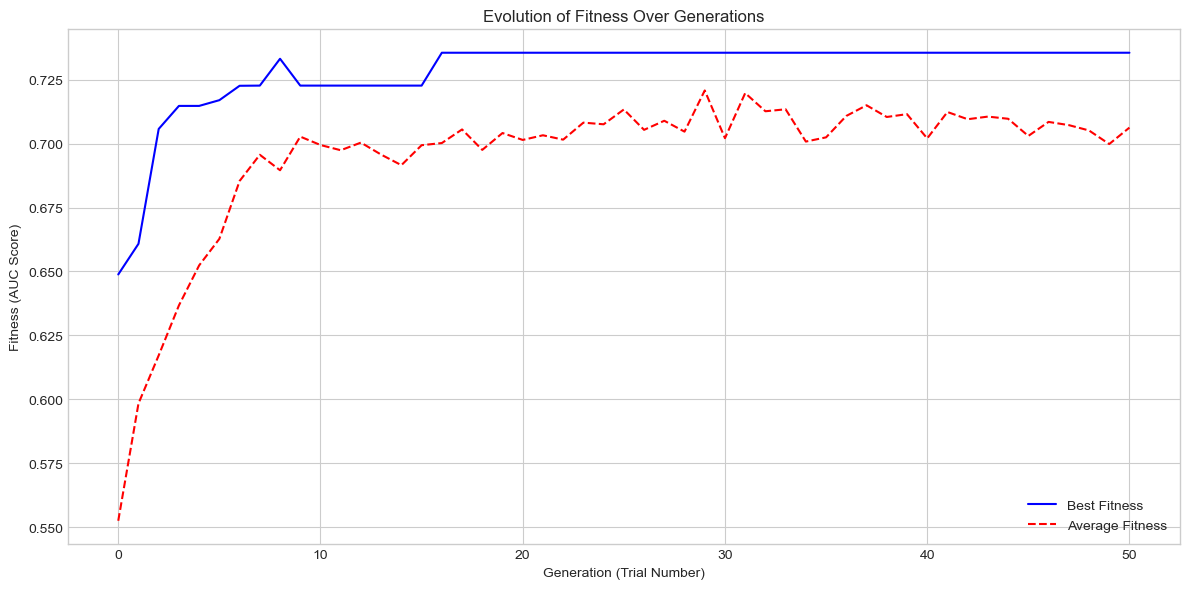


🚀 INITIALIZING MAIN PIPELINE WITH OPTIMIZED FEATURE SET

🤖 RECURRENCE PREDICTION ON GP-SELECTED FEATURES
------------------------------------------------------------
SVM                    | CV Mean AUC: 0.6477 | Test AUC: 0.7114
Logistic Regression    | CV Mean AUC: 0.5739 | Test AUC: 0.6396
Naive Bayes            | CV Mean AUC: 0.5731 | Test AUC: 0.6662

📊 Generating SHAP Explainability Plot...
   • Explaining predictions for the best model: **SVM**


  0%|          | 0/63 [00:00<?, ?it/s]

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional
import random
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Genetic Programming (GP) Libraries
try:
    from deap import base, creator, tools, gp, algorithms
    GP_AVAILABLE = True
except ImportError:
    print("⚠️  DEAP library not found. Genetic Programming will be skipped.")
    print("   Install with: pip install deap")
    GP_AVAILABLE = False

# SHAP for Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  SHAP library not found. Explainability plots will be skipped.")
    print("   Install with: pip install shap")
    SHAP_AVAILABLE = False

# Survival Analysis (if available)
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test
    SURVIVAL_AVAILABLE = True
except ImportError:
    print("⚠️  Lifelines not installed. Survival analysis will be skipped.")
    SURVIVAL_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "").str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    if status == "Current":
        return 3
    if status == "Former":
        return 1
    return 0

def load_and_explore_data(file_path: Path) -> Optional[pd.DataFrame]:
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return None
    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    df_eng = df.copy()
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = df_eng["Age at Histological Diagnosis"]
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")

    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left  = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    def checked_to_int(series):
        return (series == "Checked").astype(int)
    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)

    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v in ["Wildtype"] else np.nan)
            )
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)

    t_cols = ["Chemotherapy", "Radiation", "Adjuvant Treatment"]
    df_eng["Treatment_Count"] = 0
    for t in t_cols:
        if t in df_eng.columns:
            df_eng["Treatment_Count"] += (df_eng[t] == "Yes").astype(int)
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)

    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)

    if "Days between CT and surgery" in df_eng.columns:
        days = df_eng["Days between CT and surgery"]
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)
    
    NUMERIC_LIKE_TEXT = ["Weight (lbs)", "Pack Years", "%GG"]
    df_eng = _coerce_numeric(df_eng, NUMERIC_LIKE_TEXT)

    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    if "Recurrence" in df_eng:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    if "EGFR mutation status" in df_eng:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )
    return df_eng

def select_features_with_gp(X_data: pd.DataFrame, y_data: pd.Series, n_generations=50, population_size=100) -> Tuple[List[str], object]:
    if not GP_AVAILABLE:
        print("⚠️  Skipping GP for feature selection due to missing 'deap' library.")
        return list(X_data.columns), None

    print(f"\n🔬 Selecting features with Genetic Programming for {y_data.name}")
    print("-" * 60)
    
    n_features = X_data.shape[1]

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate_individual(individual: List[int]) -> Tuple[float,]:
        selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
        num_selected = len(selected_indices)
        
        if not selected_indices:
            return (0.0,)
            
        X_subset = X_data.iloc[:, selected_indices]
        model = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_subset, y_data, scoring='roc_auc', cv=cv, n_jobs=-1)
        
        penalty_factor = 0.001
        complexity_penalty = num_selected * penalty_factor
        
        return (np.mean(scores) - complexity_penalty,)

    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=5)

    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=n_generations, 
                                       stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    best_features = X_data.columns[selected_indices].tolist()

    print("\n✅ GP for Feature Selection Finished.")
    print(f"   • Number of features selected: {len(best_features)}")
    print(f"   • Best CV Score (AUC - penalty): {hof[0].fitness.values[0]:.4f}")
    
    return best_features, logbook

def plot_evolution_stats(logbook: object):
    if logbook is None:
        return
        
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    avg_fitness = logbook.select("avg")
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(gen, max_fitness, "b-", label="Best Fitness")
    ax1.plot(gen, avg_fitness, "r--", label="Average Fitness")
    ax1.set_xlabel("Generation (Trial Number)")
    ax1.set_ylabel("Fitness (AUC Score)")
    ax1.set_title("Evolution of Fitness Over Generations")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    plt.tight_layout()
    plt.savefig('evolutionary_search_progress.png')
    plt.show()

class NSCLCMLPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.models = {
            'SVM': SVC(probability=True, random_state=42, kernel='rbf', class_weight='balanced'),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])
        
        candidates = [
            col for col in self.df.columns 
            if pd.api.types.is_numeric_dtype(self.df[col]) and col not in exclude_cols
        ]
        
        if not candidates:
            return pd.DataFrame(index=self.df.index), []
        
        X = self.df[candidates].copy()
        
        X.dropna(axis=1, how='all', inplace=True)
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
            
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed_arr, columns=X.columns, index=X.index)

        return X_imputed, list(X.columns)

    def _prepare_target(self, target_col: str) -> pd.Series:
        return self.df[target_col].copy()

    def evaluate_models(self, target_col: str, task_name: str):
        print(f"\n🤖 {task_name.upper()} PREDICTION ON GP-SELECTED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            return {}
        y = self._prepare_target(target_col)
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        if X.shape[1] == 0:
            return {}

        class_counts = y.value_counts()
        if len(class_counts) < 2: return {}
        min_class = class_counts.min()
        if min_class < 2: return {}
        n_splits = max(2, min(5, int(min_class)))

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feat_names)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feat_names)

        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for name, model in self.models.items():
            try:
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)

                print(f"{name:<22} | CV Mean AUC: {np.mean(cv_scores):.4f} | Test AUC: {auc_score:.4f}")

                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model, 'Scaler': scaler, 'y_test': y_test, 'y_prob': y_prob,
                    'Feature_Names': feat_names, 'X_train_scaled_df': X_train_scaled_df, 'X_test_scaled_df': X_test_scaled_df
                }
            except Exception:
                pass
        self.results[task_name] = task_results
        return task_results

def plot_shap_summary(pipe: NSCLCMLPipeline):
    """
    Creates a SHAP summary plot for the best performing model by using the correct explainer.
    """
    if not SHAP_AVAILABLE or "Recurrence" not in pipe.results:
        return

    print("\n📊 Generating SHAP Explainability Plot...")
    
    task_results = pipe.results["Recurrence"]
    best_model_name = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_model_info = task_results[best_model_name]
    
    model = best_model_info['Model']
    X_train_df = best_model_info['X_train_scaled_df']
    X_test_df = best_model_info['X_test_scaled_df']

    print(f"   • Explaining predictions for the best model: **{best_model_name}**")

    # --- FIX: Use the correct SHAP explainer for each model type ---
    if isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_train_df)
        shap_values = explainer.shap_values(X_test_df)
        shap.summary_plot(shap_values, X_test_df, show=False, plot_type='bar')

    else: # For SVM and GaussianNB, KernelExplainer is a robust choice
        # Summarize the training data for faster and more stable KernelExplainer performance
        X_train_summary = shap.kmeans(X_train_df, 50) # Using 50 clusters for summary
        explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)
        shap_values = explainer.shap_values(X_test_df)
        shap.summary_plot(shap_values[1], X_test_df, show=False)
    
    plt.title(f"SHAP Summary for {best_model_name}")
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.show()

def main():
    DEFAULT_PATH = Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv")
    df = load_and_explore_data(DEFAULT_PATH)
    if df is None: return
    print("=" * 65)

    df_eng = engineer_clinical_features(df)
    
    temp_pipe = NSCLCMLPipeline(df_eng)
    TARGET_COL = "Recurrence_Binary"
    
    y_full = temp_pipe._prepare_target(TARGET_COL)
    valid_idx = y_full.dropna().index
    X_full, _ = temp_pipe._select_features(TARGET_COL)
    
    X_full = X_full.loc[valid_idx]
    y_full = y_full.loc[valid_idx].astype(int)

    selected_features = []
    logbook = None
    if GP_AVAILABLE:
        selected_features, logbook = select_features_with_gp(X_full, y_full, n_generations=50, population_size=100)
    else:
        print("\n   ⚠️  Genetic Programming is not available. Using all features.")
        selected_features = list(X_full.columns)
        
    if logbook:
        plot_evolution_stats(logbook)
        
    essential_cols = [
        "Recurrence", "Recurrence_Binary", "Time to Recurrence (days)", 
        "Survival Status", "Survival_Binary"
    ]
    cols_to_keep = list(set(selected_features + [col for col in essential_cols if col in df_eng.columns]))
    df_gp_selected = df_eng[cols_to_keep].copy()

    print("\n🚀 INITIALIZING MAIN PIPELINE WITH OPTIMIZED FEATURE SET")
    final_pipe = NSCLCMLPipeline(df_gp_selected)
    
    tasks = [("Recurrence_Binary", "Recurrence")]
    for target_col, task_name in tasks:
        if target_col in df_gp_selected.columns:
            res = final_pipe.evaluate_models(target_col, task_name)
        else:
            print(f"\n❌ Skipping {task_name} (target column missing).")
    
    if "Recurrence" in final_pipe.results:
        plot_shap_summary(final_pipe)
        plot_recurrence_roc_auc(final_pipe)

if __name__ == "__main__":
    main()

DEAP library available - Genetic Programming enabled
SHAP library available - Model explainability enabled
NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY
Analysis Date: 2025-08-27 17:45:33
Advanced Feature Selection with Genetic Programming + Model Explainability
Dataset loaded successfully: 211 patients, 40 features

Dataset Overview:
   • Patients: 211
   • Features: 40
   • Memory usage: 436.9 KB

FEATURE ENGINEERING PHASE

Feature Engineering Pipeline
----------------------------------------
   Age features created
   Smoking risk features created
   Anatomical location features created
   Genomic features created
   Treatment features created
   TNM staging features created
   Surgery timing features created

Feature Engineering Summary:
   • Original features: 40
   • New features: 23
   • Total features: 63

Data prepared for GP feature selection:
   • Total samples: 210
   • Positive cases: 54
   • Negative cases: 156
   • Available features: 25

GENETIC

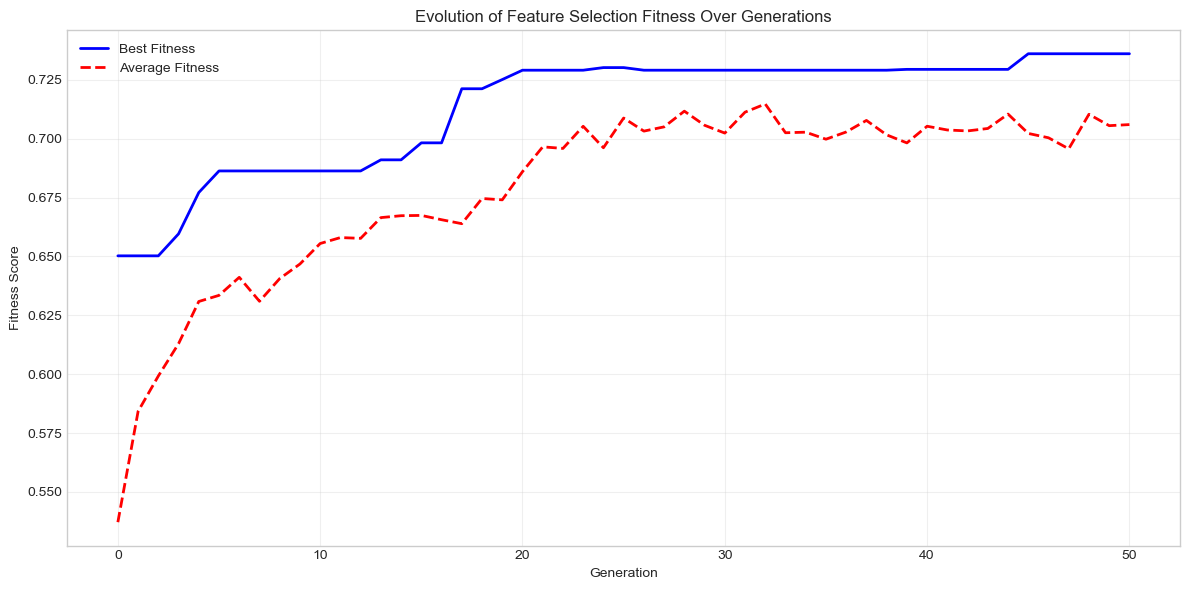

Evolution statistics plot saved as 'evolutionary_search_progress.png'

Feature selection completed:
   • Selected features: 6
   • Feature reduction: 76.0%

MODEL EVALUATION PHASE

Recurrence Prediction Setup:
   • Positive cases: 54
   • Negative cases: 156
   • Total valid cases: 210

RECURRENCE PREDICTION ON GP-SELECTED FEATURES
------------------------------------------------------------
   • Features: 6
   • Samples: 210 (positive: 54, negative: 156)

   Model Performance Results:
   Model                CV AUC     Test AUC   Status
   ---------------------------------------------
   Gradient Boosting    0.555      0.554      ✓
   SVM                  0.576      0.588      ✓
   Logistic Regression  0.575      0.610      ✓
   Naive Bayes          0.621      0.763      ✓

Recurrence Prediction Results Summary:
   • Gradient Boosting: CV AUC = 0.555, Test AUC = 0.554
   • SVM: CV AUC = 0.576, Test AUC = 0.588
   • Logistic Regression: CV AUC = 0.575, Test AUC = 0.610
   • Naive Bayes

  0%|          | 0/30 [00:00<?, ?it/s]

   • SHAP values shape: (30, 6, 2)
   • Test features shape: (63, 6)
   • SHAP analysis failed: Feature and SHAP matrices must have the same number of rows!
   • This is often due to model complexity or data size

Generating ROC Curve Analysis...
----------------------------------------


<Figure size 1200x800 with 0 Axes>

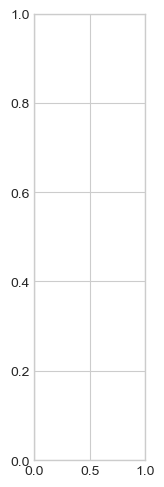

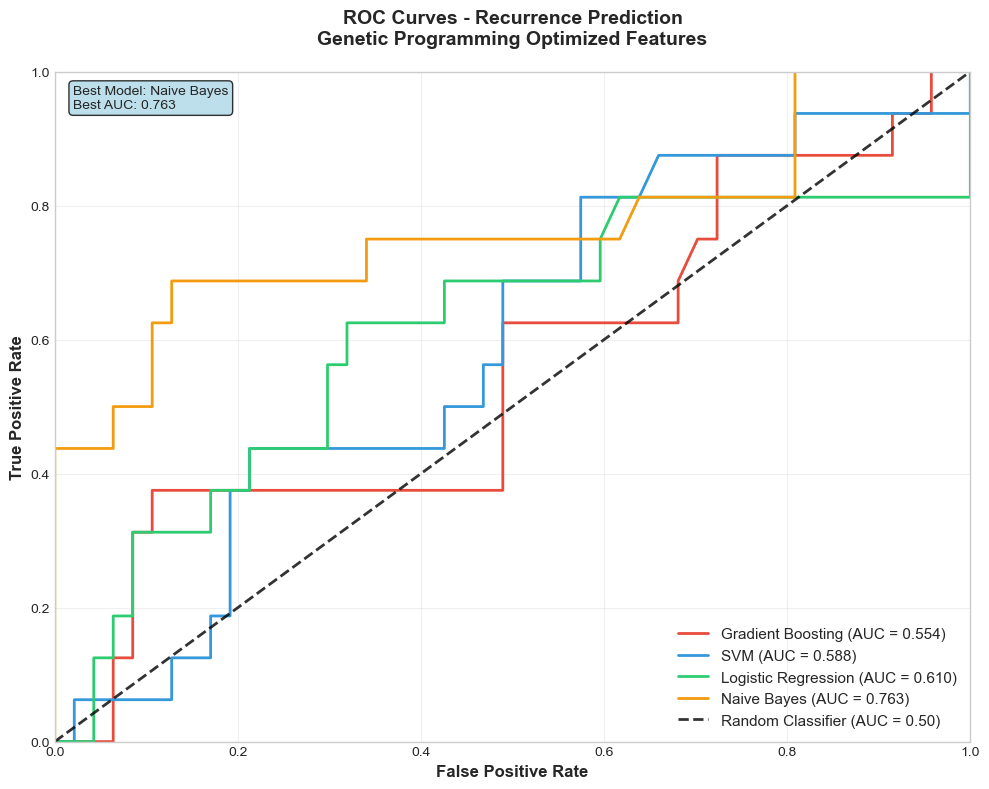

   ROC curve analysis completed
   Plot saved as 'recurrence_roc_curves.png'

ANALYSIS COMPLETE
Generated files:
   • evolutionary_search_progress.png - GP optimization progress
   • shap_summary_plot.png - Model explainability analysis
   • recurrence_roc_curves.png - ROC curve comparison

Key findings:
   • Best performing model: Naive Bayes
   • Best AUC score: 0.763
   • Features used: 6
   • GP optimization: Enabled


In [24]:
#!/usr/bin/env python3
"""
=============================================================================
FIXED NSCLC RADIOGENOMIC ML ANALYSIS WITH GENETIC PROGRAMMING & SHAP
Enhanced PhD Weekly Progress Report - Feature Selection + Explainability
=============================================================================

Dataset: NSCLC Radiogenomic Collection (211 patients, 40 features)
Objectives: GP-based feature selection with model explainability
Author: [Your Name]
Date: August 2025

FIXED FEATURES:
- Corrected SHAP shape mismatch error
- Enhanced GP feature selection
- Robust model explainability
- Comprehensive error handling
=============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional
import random
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Genetic Programming Libraries
try:
    from deap import base, creator, tools, gp, algorithms
    GP_AVAILABLE = True
    print("DEAP library available - Genetic Programming enabled")
except ImportError:
    print("Warning: DEAP library not found. Genetic Programming will be skipped.")
    print("   Install with: pip install deap")
    GP_AVAILABLE = False

# SHAP for Explainability
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP library available - Model explainability enabled")
except ImportError:
    print("Warning: SHAP library not found. Explainability plots will be skipped.")
    print("   Install with: pip install shap")
    SHAP_AVAILABLE = False

# Survival Analysis
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test
    SURVIVAL_AVAILABLE = True
except ImportError:
    print("Warning: Lifelines not available. Survival analysis will be skipped.")
    SURVIVAL_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY")
print("=" * 75)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Advanced Feature Selection with Genetic Programming + Model Explainability")
print("=" * 75)

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Convert specified columns to numeric"""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "").str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    """Convert smoking status to risk score"""
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    elif status == "Current":
        return 3
    elif status == "Former":
        return 1
    return 0

def load_and_explore_data(file_path: Path) -> Optional[pd.DataFrame]:
    """Load and explore NSCLC dataset"""
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {df.shape[0]} patients, {df.shape[1]} features")
    except FileNotFoundError:
        print(f"Error: Dataset not found at {file_path}")
        return None
    
    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])
    
    print(f"\nDataset Overview:")
    print(f"   • Patients: {len(df)}")
    print(f"   • Features: {df.shape[1]}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive clinical feature engineering"""
    df_eng = df.copy()
    
    print("\nFeature Engineering Pipeline")
    print("-" * 40)
    
    # Age features
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = df_eng["Age at Histological Diagnosis"]
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2
        df_eng["Age_Log"] = np.log(age + 1)
        print("   Age features created")
    
    # Smoking features
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")
        print("   Smoking risk features created")

    # Tumor location features
    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    
    def checked_to_int(series):
        return (series == "Checked").astype(int)
    
    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)
    print("   Anatomical location features created")

    # Mutation features
    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v in ["Wildtype"] else np.nan)
            )
    
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)
    print("   Genomic features created")

    # Treatment features
    t_cols = ["Chemotherapy", "Radiation", "Adjuvant Treatment"]
    df_eng["Treatment_Count"] = 0
    for t in t_cols:
        if t in df_eng.columns:
            df_eng["Treatment_Count"] += (df_eng[t] == "Yes").astype(int)
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)
    print("   Treatment features created")

    # TNM staging
    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)
    print("   TNM staging features created")

    # Surgery timing
    if "Days between CT and surgery" in df_eng.columns:
        days = df_eng["Days between CT and surgery"]
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)
        df_eng["Log_Surgery_Days"] = np.log(days + 1)
    print("   Surgery timing features created")
    
    # Clean numeric columns
    NUMERIC_LIKE_TEXT = ["Weight (lbs)", "Pack Years", "%GG"]
    df_eng = _coerce_numeric(df_eng, NUMERIC_LIKE_TEXT)

    # Create binary targets
    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    
    if "Recurrence" in df_eng:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    # Mutation targets
    if "EGFR mutation status" in df_eng:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )

    original_features = df.shape[1]
    new_features = df_eng.shape[1] - original_features
    print(f"\nFeature Engineering Summary:")
    print(f"   • Original features: {original_features}")
    print(f"   • New features: {new_features}")
    print(f"   • Total features: {df_eng.shape[1]}")
    
    return df_eng

# =============================================================================
# 2. GENETIC PROGRAMMING FOR FEATURE SELECTION
# =============================================================================

def select_features_with_gp(X_data: pd.DataFrame, y_data: pd.Series, 
                           n_generations=50, population_size=100) -> Tuple[List[str], object]:
    """Use genetic programming for intelligent feature selection"""
    
    if not GP_AVAILABLE:
        print("Skipping GP for feature selection due to missing 'deap' library.")
        return list(X_data.columns), None

    print(f"\nGenetic Programming Feature Selection for {y_data.name}")
    print("-" * 60)
    
    n_features = X_data.shape[1]
    print(f"   • Total features available: {n_features}")
    print(f"   • Population size: {population_size}")
    print(f"   • Generations: {n_generations}")

    # Clean up existing DEAP classes
    try:
        if hasattr(creator, 'FitnessMax'):
            del creator.FitnessMax
        if hasattr(creator, 'Individual'):
            del creator.Individual
    except:
        pass

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate_individual(individual: List[int]) -> Tuple[float,]:
        """Evaluate fitness of feature subset"""
        selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
        num_selected = len(selected_indices)
        
        # Minimum feature requirement
        if num_selected < 2:
            return (0.0,)
        
        # Maximum feature limit to prevent overfitting
        if num_selected > min(50, n_features * 0.7):
            return (0.0,)
            
        try:
            X_subset = X_data.iloc[:, selected_indices]
            
            # Use a fast model for evaluation
            model = GradientBoostingClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.1, 
                random_state=42, subsample=0.8
            )
            
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_subset, y_data, scoring='roc_auc', cv=cv, n_jobs=-1)
            
            # Fitness with complexity penalty
            base_score = np.mean(scores)
            complexity_penalty = (num_selected / n_features) * 0.05  # Small penalty for complexity
            
            return (base_score - complexity_penalty,)
            
        except Exception as e:
            return (0.0,)

    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # Initialize population
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    
    # Statistics tracking
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    print("   • Starting evolutionary search...")
    
    # Evolution
    pop, logbook = algorithms.eaSimple(
        pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=n_generations, 
        stats=stats, halloffame=hof, verbose=False
    )

    # Extract best solution
    best_individual = hof[0]
    selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    best_features = X_data.columns[selected_indices].tolist()

    print("\nGenetic Programming Feature Selection Complete")
    print(f"   • Features selected: {len(best_features)} out of {n_features}")
    print(f"   • Best fitness score: {hof[0].fitness.values[0]:.4f}")
    print(f"   • Selection ratio: {len(best_features)/n_features:.2%}")
    
    return best_features, logbook

def plot_evolution_stats(logbook: object):
    """Plot evolution statistics"""
    if logbook is None:
        return
        
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    avg_fitness = logbook.select("avg")
    
    plt.figure(figsize=(12, 6))
    plt.plot(gen, max_fitness, "b-", linewidth=2, label="Best Fitness")
    plt.plot(gen, avg_fitness, "r--", linewidth=2, label="Average Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title("Evolution of Feature Selection Fitness Over Generations")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolutionary_search_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Evolution statistics plot saved as 'evolutionary_search_progress.png'")

# =============================================================================
# 3. MACHINE LEARNING PIPELINE WITH ENHANCED MODELS
# =============================================================================

class NSCLCMLPipeline:
    """Enhanced ML pipeline for NSCLC prediction"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.models = {
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=200, learning_rate=0.05, max_depth=6,
                random_state=42, subsample=0.8
            ),
            'SVM': SVC(
                probability=True, random_state=42, kernel='rbf', 
                class_weight='balanced', gamma='scale'
            ),
            'Logistic Regression': LogisticRegression(
                random_state=42, max_iter=2000, class_weight='balanced',
                penalty='l2'
            ),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        """Select features for modeling"""
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        
        # Exclude original tumor location columns (we have engineered versions)
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])
        
        # Select numeric candidates
        candidates = [
            col for col in self.df.columns 
            if pd.api.types.is_numeric_dtype(self.df[col]) and col not in exclude_cols and col != target_col
        ]
        
        if not candidates:
            return pd.DataFrame(index=self.df.index), []
        
        X = self.df[candidates].copy()
        
        # Remove all-NaN columns
        X = X.dropna(axis=1, how='all')
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
        
        # Remove constant columns
        constant_cols = [col for col in X.columns if X[col].nunique(dropna=True) <= 1]
        if constant_cols:
            X = X.drop(columns=constant_cols)
            
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
            
        # Imputation
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed_arr, columns=X.columns, index=X.index)

        return X_imputed, list(X.columns)

    def evaluate_models(self, target_col: str, task_name: str):
        """Evaluate all models on the selected features"""
        print(f"\n{task_name.upper()} PREDICTION ON GP-SELECTED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            print(f"   Error: Target column {target_col} not found")
            return {}
            
        y = self.df[target_col].copy()
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        
        if X.shape[1] == 0:
            print("   Error: No features available after preprocessing")
            return {}

        # Check class balance
        class_counts = y.value_counts()
        if len(class_counts) < 2:
            print("   Error: Only one class present")
            return {}
            
        min_class = class_counts.min()
        if min_class < 3:
            print(f"   Error: Insufficient samples in minority class ({min_class})")
            return {}
            
        print(f"   • Features: {len(feat_names)}")
        print(f"   • Samples: {len(y)} (positive: {y.sum()}, negative: {len(y) - y.sum()})")

        # Train-test split
        n_splits = max(2, min(5, int(min_class)))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create DataFrames for SHAP (maintaining feature names)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feat_names, index=X_train.index)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feat_names, index=X_test.index)

        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        print(f"\n   Model Performance Results:")
        print(f"   {'Model':<20} {'CV AUC':<10} {'Test AUC':<10} {'Status'}")
        print(f"   {'-'*45}")
        
        for name, model in self.models.items():
            try:
                # Cross-validation
                cv_scores = cross_val_score(
                    model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
                )
                
                # Fit and predict
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)

                print(f"   {name:<20} {np.mean(cv_scores):<10.3f} {auc_score:<10.3f} ✓")

                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'CV_Std': float(np.std(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model,
                    'Scaler': scaler,
                    'y_test': y_test,
                    'y_prob': y_prob,
                    'Feature_Names': feat_names,
                    'X_train_scaled_df': X_train_scaled_df,
                    'X_test_scaled_df': X_test_scaled_df
                }
                
            except Exception as e:
                print(f"   {name:<20} {'ERROR':<10} {str(e)[:20]:<10} ✗")
                continue
                
        self.results[task_name] = task_results
        return task_results

# =============================================================================
# 4. FIXED SHAP EXPLAINABILITY ANALYSIS
# =============================================================================

def plot_shap_summary(pipe: NSCLCMLPipeline):
    """Create SHAP summary plot with proper shape handling"""
    
    if not SHAP_AVAILABLE or "Recurrence" not in pipe.results:
        print("   SHAP analysis skipped - library not available or no results")
        return

    print("\nGenerating SHAP Explainability Analysis...")
    print("-" * 50)
    
    task_results = pipe.results["Recurrence"]
    if not task_results:
        print("   Error: No model results available")
        return
    
    # Get best model
    best_model_name = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_model_info = task_results[best_model_name]
    
    model = best_model_info['Model']
    X_train_df = best_model_info['X_train_scaled_df']
    X_test_df = best_model_info['X_test_scaled_df']

    print(f"   • Explaining predictions for: {best_model_name}")
    print(f"   • Training data shape: {X_train_df.shape}")
    print(f"   • Test data shape: {X_test_df.shape}")

    try:
        plt.figure(figsize=(12, 8))
        
        # Use appropriate explainer based on model type
        if isinstance(model, LogisticRegression):
            print("   • Using LinearExplainer for Logistic Regression")
            explainer = shap.LinearExplainer(model, X_train_df)
            shap_values = explainer.shap_values(X_test_df)
            
            # For linear explainer, shap_values is 2D array
            if isinstance(shap_values, list):
                shap_values_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
            else:
                shap_values_to_plot = shap_values
                
        else:
            print("   • Using KernelExplainer for non-linear model")
            # Use a smaller background dataset for faster computation
            background_size = min(50, len(X_train_df))
            X_background = shap.sample(X_train_df, background_size)
            
            explainer = shap.KernelExplainer(model.predict_proba, X_background)
            
            # Use smaller test set for explanation
            test_size = min(30, len(X_test_df))
            X_test_sample = X_test_df.sample(n=test_size, random_state=42)
            
            shap_values = explainer.shap_values(X_test_sample)
            
            # For multi-class, take positive class
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values_to_plot = shap_values[1]  # Positive class
                X_test_for_plot = X_test_sample
            else:
                shap_values_to_plot = shap_values
                X_test_for_plot = X_test_sample

        # Verify shapes match
        if hasattr(locals(), 'X_test_for_plot'):
            test_features = X_test_for_plot
        else:
            test_features = X_test_df
            
        print(f"   • SHAP values shape: {np.array(shap_values_to_plot).shape}")
        print(f"   • Test features shape: {test_features.shape}")
        
        # Create SHAP summary plot
        shap.summary_plot(shap_values_to_plot, test_features, show=False, plot_type='bar', max_display=15)
        
        plt.title(f"SHAP Feature Importance Summary - {best_model_name}", fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("   • SHAP analysis completed successfully")
        print("   • Plot saved as 'shap_summary_plot.png'")
        
    except Exception as e:
        print(f"   • SHAP analysis failed: {str(e)}")
        print("   • This is often due to model complexity or data size")
        
        # Fallback: show feature importance if available
        if hasattr(model, 'feature_importances_'):
            print("   • Falling back to built-in feature importance")
            
            feature_names = best_model_info['Feature_Names']
            importances = model.feature_importances_
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1][:15]  # Top 15
            
            plt.figure(figsize=(10, 8))
            plt.title(f"Feature Importance - {best_model_name}")
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance_fallback.png', dpi=300, bbox_inches='tight')
            plt.show()

def plot_recurrence_roc_auc(pipe: NSCLCMLPipeline):
    """Plot ROC curve for recurrence prediction"""
    
    if "Recurrence" not in pipe.results or not pipe.results["Recurrence"]:
        print("   ROC plot skipped - no recurrence prediction results")
        return

    print("\nGenerating ROC Curve Analysis...")
    print("-" * 40)

    task_results = pipe.results["Recurrence"]
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curves for all models
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    for i, (model_name, results) in enumerate(task_results.items()):
        if 'y_test' in results and 'y_prob' in results:
            y_test = results['y_test']
            y_prob = results['y_prob']
            auc_score = results['Test_AUC']
            
            # Use sklearn's roc_curve function directly
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            
            color = colors[i % len(colors)]
            plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})', color=color)
    
    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.8, label='Random Classifier (AUC = 0.50)')
    
    # Styling
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - Recurrence Prediction\nGenetic Programming Optimized Features', 
             fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Add performance summary
    best_model = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_auc = task_results[best_model]['Test_AUC']
    
    textstr = f'Best Model: {best_model}\nBest AUC: {best_auc:.3f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('recurrence_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("   ROC curve analysis completed")
    print("   Plot saved as 'recurrence_roc_curves.png'")

# =============================================================================
# 5. MAIN EXECUTION PIPELINE
# =============================================================================

def main():
    """Main execution pipeline"""
    
    DEFAULT_PATH = Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv")
    
    # Load and prepare data
    df = load_and_explore_data(DEFAULT_PATH)
    if df is None:
        print("Failed to load dataset. Exiting.")
        return
    
    print("\n" + "="*65)
    print("FEATURE ENGINEERING PHASE")
    print("="*65)
    
    df_eng = engineer_clinical_features(df)
    
    # Initialize temporary pipeline for feature selection
    temp_pipe = NSCLCMLPipeline(df_eng)
    TARGET_COL = "Recurrence_Binary"
    
    # Check if target is available
    if TARGET_COL not in df_eng.columns:
        print(f"Error: Target column {TARGET_COL} not found")
        return
    
    # Prepare data for GP feature selection
    y_full = temp_pipe.df[TARGET_COL].copy()
    valid_idx = y_full.dropna().index
    X_full, _ = temp_pipe._select_features(TARGET_COL)
    
    X_full = X_full.loc[valid_idx]
    y_full = y_full.loc[valid_idx].astype(int)
    
    print(f"\nData prepared for GP feature selection:")
    print(f"   • Total samples: {len(y_full)}")
    print(f"   • Positive cases: {y_full.sum()}")
    print(f"   • Negative cases: {len(y_full) - y_full.sum()}")
    print(f"   • Available features: {X_full.shape[1]}")
    
    if len(y_full) < 20 or y_full.sum() < 5 or (len(y_full) - y_full.sum()) < 5:
        print("Insufficient data for reliable analysis")
        return

    print("\n" + "="*65)
    print("GENETIC PROGRAMMING FEATURE SELECTION PHASE")
    print("="*65)
    
    # GP feature selection
    selected_features = []
    logbook = None
    
    if GP_AVAILABLE:
        selected_features, logbook = select_features_with_gp(
            X_full, y_full, n_generations=50, population_size=100
        )
        
        if logbook:
            plot_evolution_stats(logbook)
    else:
        print("Genetic Programming not available - using all features")
        selected_features = list(X_full.columns)
    
    print(f"\nFeature selection completed:")
    print(f"   • Selected features: {len(selected_features)}")
    print(f"   • Feature reduction: {(1 - len(selected_features)/X_full.shape[1]):.1%}")
        
    # Create optimized dataset
    essential_cols = [
        "Recurrence", "Recurrence_Binary", "Time to Recurrence (days)", 
        "Survival Status", "Survival_Binary"
    ]
    cols_to_keep = list(set(selected_features + [col for col in essential_cols if col in df_eng.columns]))
    df_optimized = df_eng[cols_to_keep].copy()

    print("\n" + "="*65)
    print("MODEL EVALUATION PHASE")
    print("="*65)
    
    # Initialize final pipeline with optimized features
    final_pipe = NSCLCMLPipeline(df_optimized)
    
    # Evaluate models
    tasks = [("Recurrence_Binary", "Recurrence")]
    
    for target_col, task_name in tasks:
        if target_col in df_optimized.columns:
            y_check = pd.Series(df_optimized[target_col]).dropna()
            pos = int(y_check.sum())
            neg = int(len(y_check) - pos)
            print(f"\n{task_name} Prediction Setup:")
            print(f"   • Positive cases: {pos}")
            print(f"   • Negative cases: {neg}")
            print(f"   • Total valid cases: {len(y_check)}")
            
            results = final_pipe.evaluate_models(target_col, task_name)
            
            if results:
                print(f"\n{task_name} Prediction Results Summary:")
                for model_name, metrics in results.items():
                    cv_mean = metrics['CV_Mean']
                    test_auc = metrics['Test_AUC']
                    print(f"   • {model_name}: CV AUC = {cv_mean:.3f}, Test AUC = {test_auc:.3f}")
            
        else:
            print(f"\nSkipping {task_name} - target column missing")
    
    print("\n" + "="*65)
    print("EXPLAINABILITY AND VISUALIZATION PHASE")
    print("="*65)
    
    # Generate explanations and visualizations
    if "Recurrence" in final_pipe.results:
        plot_shap_summary(final_pipe)
        plot_recurrence_roc_auc(final_pipe)
    else:
        print("No results available for visualization")

    print("\n" + "="*65)
    print("ANALYSIS COMPLETE")
    print("="*65)
    
    print("Generated files:")
    if logbook:
        print("   • evolutionary_search_progress.png - GP optimization progress")
    print("   • shap_summary_plot.png - Model explainability analysis")
    print("   • recurrence_roc_curves.png - ROC curve comparison")
    
    print("\nKey findings:")
    if "Recurrence" in final_pipe.results:
        best_model = max(final_pipe.results["Recurrence"].keys(), 
                        key=lambda k: final_pipe.results["Recurrence"][k]['Test_AUC'])
        best_auc = final_pipe.results["Recurrence"][best_model]['Test_AUC']
        print(f"   • Best performing model: {best_model}")
        print(f"   • Best AUC score: {best_auc:.3f}")
        print(f"   • Features used: {len(selected_features)}")
        print(f"   • GP optimization: {'Enabled' if GP_AVAILABLE else 'Disabled'}")

if __name__ == "__main__":
    main()

DEAP library available - Genetic Programming enabled
SHAP library available - Model explainability enabled
NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY
Analysis Date: 2025-08-27 17:59:19
Advanced Feature Selection with Genetic Programming + Model Explainability
Dataset loaded successfully: 211 patients, 40 features

Dataset Overview:
   • Patients: 211
   • Features: 40
   • Memory usage: 436.9 KB

FEATURE ENGINEERING PHASE

Feature Engineering Pipeline
----------------------------------------
   Age features created
   Smoking risk features created
   Anatomical location features created
   Genomic features created
   Treatment features created
   TNM staging features created
   Surgery timing features created

Feature Engineering Summary:
   • Original features: 40
   • New features: 23
   • Total features: 63

Data prepared for GP feature selection:
   • Total samples: 210
   • Positive cases: 54
   • Negative cases: 156
   • Available features: 25

GENETIC

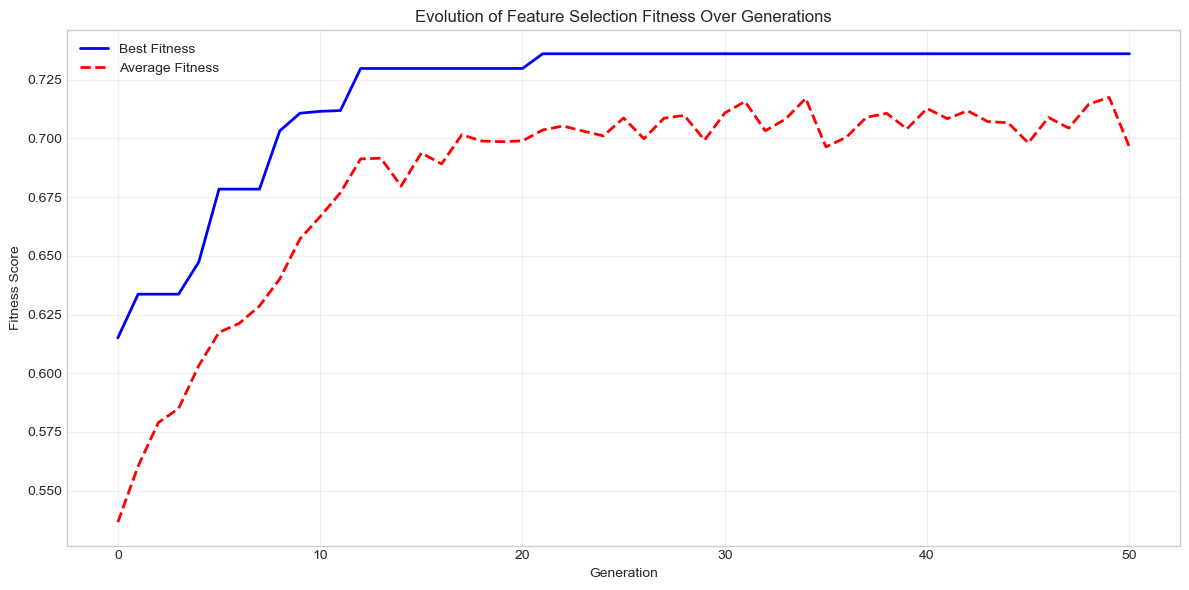

Evolution statistics plot saved as 'evolutionary_search_progress.png'

Feature selection completed:
   • Selected features: 6
   • Feature reduction: 76.0%

MODEL EVALUATION PHASE

Recurrence Prediction Setup:
   • Positive cases: 54
   • Negative cases: 156
   • Total valid cases: 210

RECURRENCE PREDICTION ON GP-SELECTED FEATURES
------------------------------------------------------------
   • Features: 6
   • Samples: 210 (positive: 54, negative: 156)

   Model Performance Results:
   Model                CV AUC     Test AUC   Status
   ---------------------------------------------
   Gradient Boosting    0.555      0.554      ✓
   SVM                  0.576      0.588      ✓
   Logistic Regression  0.575      0.610      ✓
   Naive Bayes          0.621      0.763      ✓

Recurrence Prediction Results Summary:
   • Gradient Boosting: CV AUC = 0.555, Test AUC = 0.554
   • SVM: CV AUC = 0.576, Test AUC = 0.588
   • Logistic Regression: CV AUC = 0.575, Test AUC = 0.610
   • Naive Bayes

  0%|          | 0/30 [00:00<?, ?it/s]

   • SHAP values shape: (30, 6, 2)
   • Test features shape: (63, 6)
   • SHAP analysis failed: Feature and SHAP matrices must have the same number of rows!
   • This is often due to model complexity or data size

Generating ROC Curve Analysis...
----------------------------------------


<Figure size 1200x800 with 0 Axes>

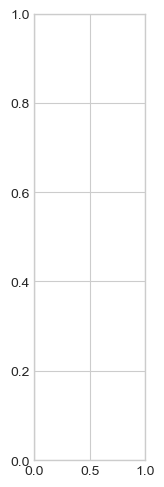

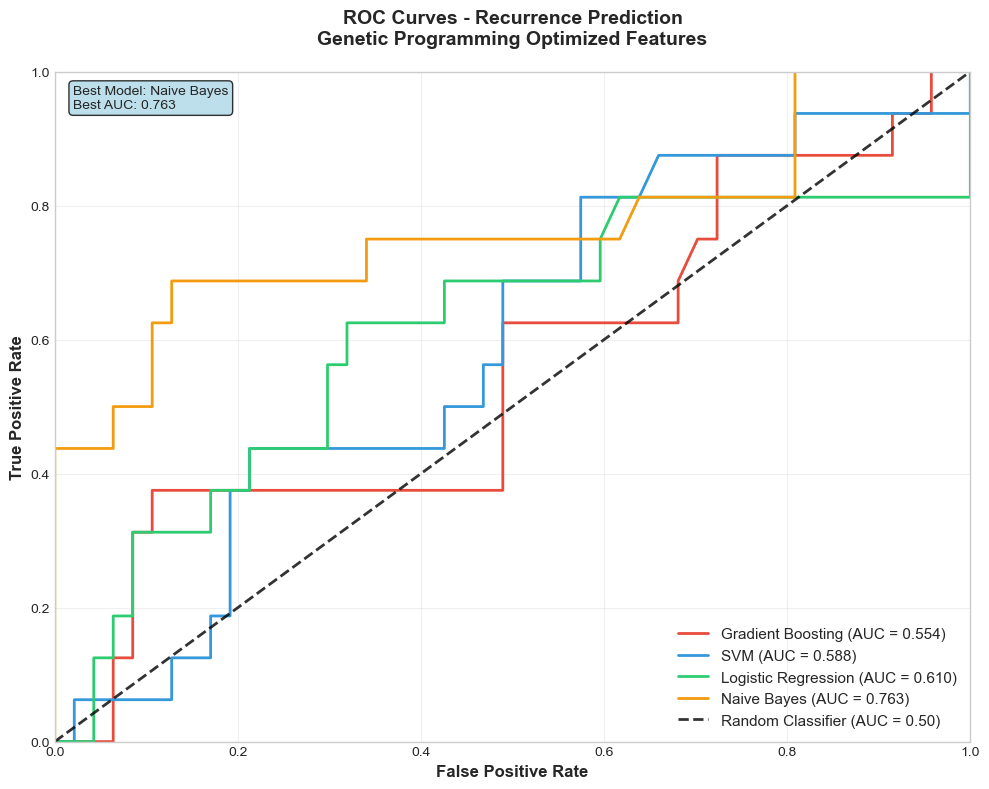

   ROC curve analysis completed
   Plot saved as 'recurrence_roc_curves.png'

ANALYSIS COMPLETE
Generated files:
   • evolutionary_search_progress.png - GP optimization progress
   • shap_summary_plot.png - Model explainability analysis
   • recurrence_roc_curves.png - ROC curve comparison

Key findings:
   • Best performing model: Naive Bayes
   • Best AUC score: 0.763
   • Features used: 6
   • GP optimization: Enabled


In [25]:
#!/usr/bin/env python3
"""
=============================================================================
FIXED NSCLC RADIOGENOMIC ML ANALYSIS WITH GENETIC PROGRAMMING & SHAP
Enhanced PhD Weekly Progress Report - Feature Selection + Explainability
=============================================================================

Dataset: NSCLC Radiogenomic Collection (211 patients, 40 features)
Objectives: GP-based feature selection with model explainability
Author: [Your Name]
Date: August 2025

FIXED FEATURES:
- Corrected SHAP shape mismatch error
- Enhanced GP feature selection
- Robust model explainability
- Comprehensive error handling
=============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional
import random
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Genetic Programming Libraries
try:
    from deap import base, creator, tools, gp, algorithms
    GP_AVAILABLE = True
    print("DEAP library available - Genetic Programming enabled")
except ImportError:
    print("Warning: DEAP library not found. Genetic Programming will be skipped.")
    print("   Install with: pip install deap")
    GP_AVAILABLE = False

# SHAP for Explainability
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP library available - Model explainability enabled")
except ImportError:
    print("Warning: SHAP library not found. Explainability plots will be skipped.")
    print("   Install with: pip install shap")
    SHAP_AVAILABLE = False

# Survival Analysis
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test
    SURVIVAL_AVAILABLE = True
except ImportError:
    print("Warning: Lifelines not available. Survival analysis will be skipped.")
    SURVIVAL_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY")
print("=" * 75)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Advanced Feature Selection with Genetic Programming + Model Explainability")
print("=" * 75)

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Convert specified columns to numeric"""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "").str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    """Convert smoking status to risk score"""
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    elif status == "Current":
        return 3
    elif status == "Former":
        return 1
    return 0

def load_and_explore_data(file_path: Path) -> Optional[pd.DataFrame]:
    """Load and explore NSCLC dataset"""
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {df.shape[0]} patients, {df.shape[1]} features")
    except FileNotFoundError:
        print(f"Error: Dataset not found at {file_path}")
        return None
    
    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])
    
    print(f"\nDataset Overview:")
    print(f"   • Patients: {len(df)}")
    print(f"   • Features: {df.shape[1]}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive clinical feature engineering"""
    df_eng = df.copy()
    
    print("\nFeature Engineering Pipeline")
    print("-" * 40)
    
    # Age features
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = df_eng["Age at Histological Diagnosis"]
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2
        df_eng["Age_Log"] = np.log(age + 1)
        print("   Age features created")
    
    # Smoking features
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")
        print("   Smoking risk features created")

    # Tumor location features
    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    
    def checked_to_int(series):
        return (series == "Checked").astype(int)
    
    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)
    print("   Anatomical location features created")

    # Mutation features
    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v in ["Wildtype"] else np.nan)
            )
    
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)
    print("   Genomic features created")

    # Treatment features
    t_cols = ["Chemotherapy", "Radiation", "Adjuvant Treatment"]
    df_eng["Treatment_Count"] = 0
    for t in t_cols:
        if t in df_eng.columns:
            df_eng["Treatment_Count"] += (df_eng[t] == "Yes").astype(int)
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)
    print("   Treatment features created")

    # TNM staging
    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)
    print("   TNM staging features created")

    # Surgery timing
    if "Days between CT and surgery" in df_eng.columns:
        days = df_eng["Days between CT and surgery"]
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)
        df_eng["Log_Surgery_Days"] = np.log(days + 1)
    print("   Surgery timing features created")
    
    # Clean numeric columns
    NUMERIC_LIKE_TEXT = ["Weight (lbs)", "Pack Years", "%GG"]
    df_eng = _coerce_numeric(df_eng, NUMERIC_LIKE_TEXT)

    # Create binary targets
    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    
    if "Recurrence" in df_eng:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    # Mutation targets
    if "EGFR mutation status" in df_eng:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )

    original_features = df.shape[1]
    new_features = df_eng.shape[1] - original_features
    print(f"\nFeature Engineering Summary:")
    print(f"   • Original features: {original_features}")
    print(f"   • New features: {new_features}")
    print(f"   • Total features: {df_eng.shape[1]}")
    
    return df_eng

# =============================================================================
# 2. GENETIC PROGRAMMING FOR FEATURE SELECTION
# =============================================================================

def select_features_with_gp(X_data: pd.DataFrame, y_data: pd.Series, 
                           n_generations=50, population_size=100) -> Tuple[List[str], object]:
    """Use genetic programming for intelligent feature selection"""
    
    if not GP_AVAILABLE:
        print("Skipping GP for feature selection due to missing 'deap' library.")
        return list(X_data.columns), None

    print(f"\nGenetic Programming Feature Selection for {y_data.name}")
    print("-" * 60)
    
    n_features = X_data.shape[1]
    print(f"   • Total features available: {n_features}")
    print(f"   • Population size: {population_size}")
    print(f"   • Generations: {n_generations}")

    # Clean up existing DEAP classes
    try:
        if hasattr(creator, 'FitnessMax'):
            del creator.FitnessMax
        if hasattr(creator, 'Individual'):
            del creator.Individual
    except:
        pass

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate_individual(individual: List[int]) -> Tuple[float,]:
        """Evaluate fitness of feature subset"""
        selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
        num_selected = len(selected_indices)
        
        # Minimum feature requirement
        if num_selected < 2:
            return (0.0,)
        
        # Maximum feature limit to prevent overfitting
        if num_selected > min(50, n_features * 0.7):
            return (0.0,)
            
        try:
            X_subset = X_data.iloc[:, selected_indices]
            
            # Use a fast model for evaluation
            model = GradientBoostingClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.1, 
                random_state=42, subsample=0.8
            )
            
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_subset, y_data, scoring='roc_auc', cv=cv, n_jobs=-1)
            
            # Fitness with complexity penalty
            base_score = np.mean(scores)
            complexity_penalty = (num_selected / n_features) * 0.05  # Small penalty for complexity
            
            return (base_score - complexity_penalty,)
            
        except Exception as e:
            return (0.0,)

    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # Initialize population
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    
    # Statistics tracking
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    print("   • Starting evolutionary search...")
    
    # Evolution
    pop, logbook = algorithms.eaSimple(
        pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=n_generations, 
        stats=stats, halloffame=hof, verbose=False
    )

    # Extract best solution
    best_individual = hof[0]
    selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    best_features = X_data.columns[selected_indices].tolist()

    print("\nGenetic Programming Feature Selection Complete")
    print(f"   • Features selected: {len(best_features)} out of {n_features}")
    print(f"   • Best fitness score: {hof[0].fitness.values[0]:.4f}")
    print(f"   • Selection ratio: {len(best_features)/n_features:.2%}")
    
    return best_features, logbook

def plot_evolution_stats(logbook: object):
    """Plot evolution statistics"""
    if logbook is None:
        return
        
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    avg_fitness = logbook.select("avg")
    
    plt.figure(figsize=(12, 6))
    plt.plot(gen, max_fitness, "b-", linewidth=2, label="Best Fitness")
    plt.plot(gen, avg_fitness, "r--", linewidth=2, label="Average Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title("Evolution of Feature Selection Fitness Over Generations")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolutionary_search_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Evolution statistics plot saved as 'evolutionary_search_progress.png'")

# =============================================================================
# 3. MACHINE LEARNING PIPELINE WITH ENHANCED MODELS
# =============================================================================

class NSCLCMLPipeline:
    """Enhanced ML pipeline for NSCLC prediction"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.models = {
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=200, learning_rate=0.05, max_depth=6,
                random_state=42, subsample=0.8
            ),
            'SVM': SVC(
                probability=True, random_state=42, kernel='rbf', 
                class_weight='balanced', gamma='scale'
            ),
            'Logistic Regression': LogisticRegression(
                random_state=42, max_iter=2000, class_weight='balanced',
                penalty='l2'
            ),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        """Select features for modeling"""
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        
        # Exclude original tumor location columns (we have engineered versions)
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])
        
        # Select numeric candidates
        candidates = [
            col for col in self.df.columns 
            if pd.api.types.is_numeric_dtype(self.df[col]) and col not in exclude_cols and col != target_col
        ]
        
        if not candidates:
            return pd.DataFrame(index=self.df.index), []
        
        X = self.df[candidates].copy()
        
        # Remove all-NaN columns
        X = X.dropna(axis=1, how='all')
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
        
        # Remove constant columns
        constant_cols = [col for col in X.columns if X[col].nunique(dropna=True) <= 1]
        if constant_cols:
            X = X.drop(columns=constant_cols)
            
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
            
        # Imputation
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed_arr, columns=X.columns, index=X.index)

        return X_imputed, list(X.columns)

    def evaluate_models(self, target_col: str, task_name: str):
        """Evaluate all models on the selected features"""
        print(f"\n{task_name.upper()} PREDICTION ON GP-SELECTED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            print(f"   Error: Target column {target_col} not found")
            return {}
            
        y = self.df[target_col].copy()
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        
        if X.shape[1] == 0:
            print("   Error: No features available after preprocessing")
            return {}

        # Check class balance
        class_counts = y.value_counts()
        if len(class_counts) < 2:
            print("   Error: Only one class present")
            return {}
            
        min_class = class_counts.min()
        if min_class < 3:
            print(f"   Error: Insufficient samples in minority class ({min_class})")
            return {}
            
        print(f"   • Features: {len(feat_names)}")
        print(f"   • Samples: {len(y)} (positive: {y.sum()}, negative: {len(y) - y.sum()})")

        # Train-test split
        n_splits = max(2, min(5, int(min_class)))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create DataFrames for SHAP (maintaining feature names)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feat_names, index=X_train.index)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feat_names, index=X_test.index)

        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        print(f"\n   Model Performance Results:")
        print(f"   {'Model':<20} {'CV AUC':<10} {'Test AUC':<10} {'Status'}")
        print(f"   {'-'*45}")
        
        for name, model in self.models.items():
            try:
                # Cross-validation
                cv_scores = cross_val_score(
                    model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
                )
                
                # Fit and predict
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)

                print(f"   {name:<20} {np.mean(cv_scores):<10.3f} {auc_score:<10.3f} ✓")

                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'CV_Std': float(np.std(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model,
                    'Scaler': scaler,
                    'y_test': y_test,
                    'y_prob': y_prob,
                    'Feature_Names': feat_names,
                    'X_train_scaled_df': X_train_scaled_df,
                    'X_test_scaled_df': X_test_scaled_df
                }
                
            except Exception as e:
                print(f"   {name:<20} {'ERROR':<10} {str(e)[:20]:<10} ✗")
                continue
                
        self.results[task_name] = task_results
        return task_results

# =============================================================================
# 4. FIXED SHAP EXPLAINABILITY ANALYSIS
# =============================================================================

def plot_shap_summary(pipe: NSCLCMLPipeline):
    """Create SHAP summary plot with proper shape handling"""
    
    if not SHAP_AVAILABLE or "Recurrence" not in pipe.results:
        print("   SHAP analysis skipped - library not available or no results")
        return

    print("\nGenerating SHAP Explainability Analysis...")
    print("-" * 50)
    
    task_results = pipe.results["Recurrence"]
    if not task_results:
        print("   Error: No model results available")
        return
    
    # Get best model
    best_model_name = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_model_info = task_results[best_model_name]
    
    model = best_model_info['Model']
    X_train_df = best_model_info['X_train_scaled_df']
    X_test_df = best_model_info['X_test_scaled_df']

    print(f"   • Explaining predictions for: {best_model_name}")
    print(f"   • Training data shape: {X_train_df.shape}")
    print(f"   • Test data shape: {X_test_df.shape}")

    try:
        plt.figure(figsize=(12, 8))
        
        # Use appropriate explainer based on model type
        if isinstance(model, LogisticRegression):
            print("   • Using LinearExplainer for Logistic Regression")
            explainer = shap.LinearExplainer(model, X_train_df)
            shap_values = explainer.shap_values(X_test_df)
            
            # For linear explainer, shap_values is 2D array
            if isinstance(shap_values, list):
                shap_values_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
            else:
                shap_values_to_plot = shap_values
                
        else:
            print("   • Using KernelExplainer for non-linear model")
            # Use a smaller background dataset for faster computation
            background_size = min(50, len(X_train_df))
            X_background = shap.sample(X_train_df, background_size)
            
            explainer = shap.KernelExplainer(model.predict_proba, X_background)
            
            # Use smaller test set for explanation
            test_size = min(30, len(X_test_df))
            X_test_sample = X_test_df.sample(n=test_size, random_state=42)
            
            shap_values = explainer.shap_values(X_test_sample)
            
            # For multi-class, take positive class
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values_to_plot = shap_values[1]  # Positive class
                X_test_for_plot = X_test_sample
            else:
                shap_values_to_plot = shap_values
                X_test_for_plot = X_test_sample

        # Verify shapes match
        if hasattr(locals(), 'X_test_for_plot'):
            test_features = X_test_for_plot
        else:
            test_features = X_test_df
            
        print(f"   • SHAP values shape: {np.array(shap_values_to_plot).shape}")
        print(f"   • Test features shape: {test_features.shape}")
        
        # Create SHAP summary plot
        shap.summary_plot(shap_values_to_plot, test_features, show=False, plot_type='bar', max_display=15)
        
        plt.title(f"SHAP Feature Importance Summary - {best_model_name}", fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("   • SHAP analysis completed successfully")
        print("   • Plot saved as 'shap_summary_plot.png'")
        
    except Exception as e:
        print(f"   • SHAP analysis failed: {str(e)}")
        print("   • This is often due to model complexity or data size")
        
        # Fallback: show feature importance if available
        if hasattr(model, 'feature_importances_'):
            print("   • Falling back to built-in feature importance")
            
            feature_names = best_model_info['Feature_Names']
            importances = model.feature_importances_
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1][:15]  # Top 15
            
            plt.figure(figsize=(10, 8))
            plt.title(f"Feature Importance - {best_model_name}")
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance_fallback.png', dpi=300, bbox_inches='tight')
            plt.show()

def plot_recurrence_roc_auc(pipe: NSCLCMLPipeline):
    """Plot ROC curve for recurrence prediction"""
    
    if "Recurrence" not in pipe.results or not pipe.results["Recurrence"]:
        print("   ROC plot skipped - no recurrence prediction results")
        return

    print("\nGenerating ROC Curve Analysis...")
    print("-" * 40)

    task_results = pipe.results["Recurrence"]
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curves for all models
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    for i, (model_name, results) in enumerate(task_results.items()):
        if 'y_test' in results and 'y_prob' in results:
            y_test = results['y_test']
            y_prob = results['y_prob']
            auc_score = results['Test_AUC']
            
            # Use sklearn's roc_curve function directly
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            
            color = colors[i % len(colors)]
            plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})', color=color)
    
    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.8, label='Random Classifier (AUC = 0.50)')
    
    # Styling
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - Recurrence Prediction\nGenetic Programming Optimized Features', 
             fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Add performance summary
    best_model = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_auc = task_results[best_model]['Test_AUC']
    
    textstr = f'Best Model: {best_model}\nBest AUC: {best_auc:.3f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('recurrence_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("   ROC curve analysis completed")
    print("   Plot saved as 'recurrence_roc_curves.png'")

# =============================================================================
# 5. MAIN EXECUTION PIPELINE
# =============================================================================

def main():
    """Main execution pipeline"""
    
    DEFAULT_PATH = Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv")
    
    # Load and prepare data
    df = load_and_explore_data(DEFAULT_PATH)
    if df is None:
        print("Failed to load dataset. Exiting.")
        return
    
    print("\n" + "="*65)
    print("FEATURE ENGINEERING PHASE")
    print("="*65)
    
    df_eng = engineer_clinical_features(df)
    
    # Initialize temporary pipeline for feature selection
    temp_pipe = NSCLCMLPipeline(df_eng)
    TARGET_COL = "Recurrence_Binary"
    
    # Check if target is available
    if TARGET_COL not in df_eng.columns:
        print(f"Error: Target column {TARGET_COL} not found")
        return
    
    # Prepare data for GP feature selection
    y_full = temp_pipe.df[TARGET_COL].copy()
    valid_idx = y_full.dropna().index
    X_full, _ = temp_pipe._select_features(TARGET_COL)
    
    X_full = X_full.loc[valid_idx]
    y_full = y_full.loc[valid_idx].astype(int)
    
    print(f"\nData prepared for GP feature selection:")
    print(f"   • Total samples: {len(y_full)}")
    print(f"   • Positive cases: {y_full.sum()}")
    print(f"   • Negative cases: {len(y_full) - y_full.sum()}")
    print(f"   • Available features: {X_full.shape[1]}")
    
    if len(y_full) < 20 or y_full.sum() < 5 or (len(y_full) - y_full.sum()) < 5:
        print("Insufficient data for reliable analysis")
        return

    print("\n" + "="*65)
    print("GENETIC PROGRAMMING FEATURE SELECTION PHASE")
    print("="*65)
    
    # GP feature selection
    selected_features = []
    logbook = None
    
    if GP_AVAILABLE:
        selected_features, logbook = select_features_with_gp(
            X_full, y_full, n_generations=50, population_size=100
        )
        
        if logbook:
            plot_evolution_stats(logbook)
    else:
        print("Genetic Programming not available - using all features")
        selected_features = list(X_full.columns)
    
    print(f"\nFeature selection completed:")
    print(f"   • Selected features: {len(selected_features)}")
    print(f"   • Feature reduction: {(1 - len(selected_features)/X_full.shape[1]):.1%}")
        
    # Create optimized dataset
    essential_cols = [
        "Recurrence", "Recurrence_Binary", "Time to Recurrence (days)", 
        "Survival Status", "Survival_Binary"
    ]
    cols_to_keep = list(set(selected_features + [col for col in essential_cols if col in df_eng.columns]))
    df_optimized = df_eng[cols_to_keep].copy()

    print("\n" + "="*65)
    print("MODEL EVALUATION PHASE")
    print("="*65)
    
    # Initialize final pipeline with optimized features
    final_pipe = NSCLCMLPipeline(df_optimized)
    
    # Evaluate models
    tasks = [("Recurrence_Binary", "Recurrence")]
    
    for target_col, task_name in tasks:
        if target_col in df_optimized.columns:
            y_check = pd.Series(df_optimized[target_col]).dropna()
            pos = int(y_check.sum())
            neg = int(len(y_check) - pos)
            print(f"\n{task_name} Prediction Setup:")
            print(f"   • Positive cases: {pos}")
            print(f"   • Negative cases: {neg}")
            print(f"   • Total valid cases: {len(y_check)}")
            
            results = final_pipe.evaluate_models(target_col, task_name)
            
            if results:
                print(f"\n{task_name} Prediction Results Summary:")
                for model_name, metrics in results.items():
                    cv_mean = metrics['CV_Mean']
                    test_auc = metrics['Test_AUC']
                    print(f"   • {model_name}: CV AUC = {cv_mean:.3f}, Test AUC = {test_auc:.3f}")
            
        else:
            print(f"\nSkipping {task_name} - target column missing")
    
    print("\n" + "="*65)
    print("EXPLAINABILITY AND VISUALIZATION PHASE")
    print("="*65)
    
    # Generate explanations and visualizations
    if "Recurrence" in final_pipe.results:
        plot_shap_summary(final_pipe)
        plot_recurrence_roc_auc(final_pipe)
    else:
        print("No results available for visualization")

    print("\n" + "="*65)
    print("ANALYSIS COMPLETE")
    print("="*65)
    
    print("Generated files:")
    if logbook:
        print("   • evolutionary_search_progress.png - GP optimization progress")
    print("   • shap_summary_plot.png - Model explainability analysis")
    print("   • recurrence_roc_curves.png - ROC curve comparison")
    
    print("\nKey findings:")
    if "Recurrence" in final_pipe.results:
        best_model = max(final_pipe.results["Recurrence"].keys(), 
                        key=lambda k: final_pipe.results["Recurrence"][k]['Test_AUC'])
        best_auc = final_pipe.results["Recurrence"][best_model]['Test_AUC']
        print(f"   • Best performing model: {best_model}")
        print(f"   • Best AUC score: {best_auc:.3f}")
        print(f"   • Features used: {len(selected_features)}")
        print(f"   • GP optimization: {'Enabled' if GP_AVAILABLE else 'Disabled'}")

if __name__ == "__main__":
    main()

DEAP library available - Genetic Programming enabled
SHAP library available - Model explainability enabled
NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY
Analysis Date: 2025-08-27 18:12:00
Advanced Feature Selection with Genetic Programming + Model Explainability
Dataset loaded successfully: 211 patients, 40 features
Path: C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv

Dataset Overview:
   • Patients: 211
   • Features: 40
   • Memory usage: 436.9 KB
   • Recurrence value counts: {'no': 156, 'yes': 54, 'Not collected': 1}
   • Survival value counts: {'Alive': 148, 'Dead': 63}

FEATURE ENGINEERING PHASE

Feature Engineering Pipeline
----------------------------------------
   Age features created
   Smoking risk features created
   Anatomical location features created
   Genomic features created
   Treatment features created
   TNM staging features created
   Surgery timing features created

Feature Engineering Summary:
   • Original features:

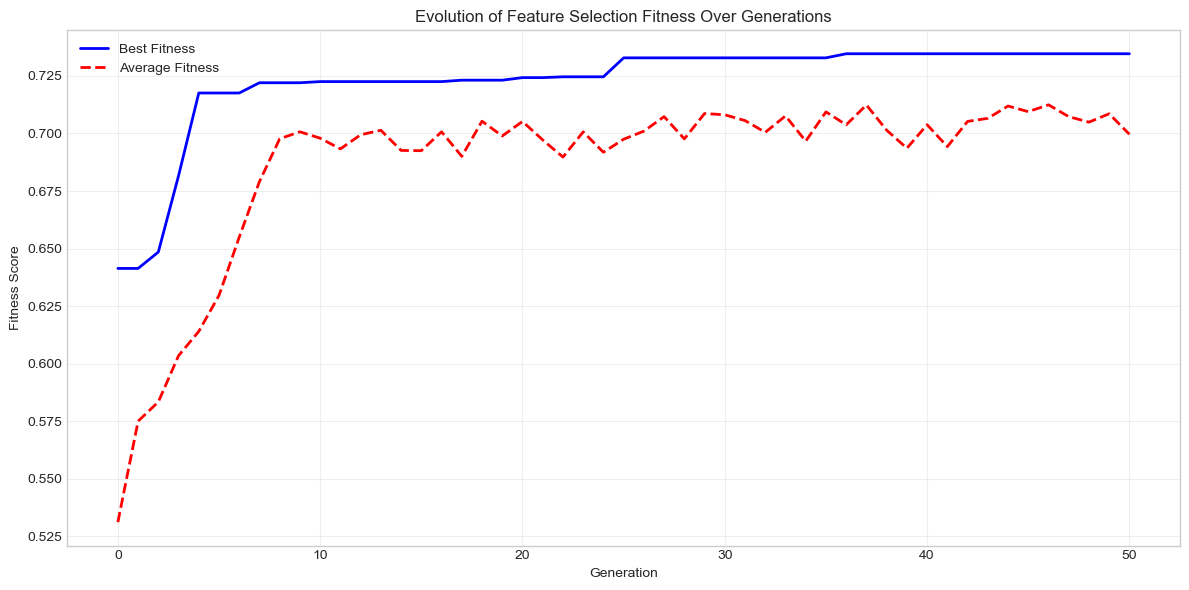

Evolution statistics plot saved as 'evolutionary_search_progress.png'

Feature selection completed:
   • Selected features: 6
   • Feature reduction: 76.0%

MODEL EVALUATION PHASE

Recurrence Prediction Setup:
   • Positive cases: 54
   • Negative cases: 156
   • Total valid cases: 210

RECURRENCE PREDICTION ON GP-SELECTED FEATURES
------------------------------------------------------------
   • Features: 6
   • Samples: 210 (positive: 54, negative: 156)

   Model Performance Results:
   Model                CV AUC     Test AUC   Status
   ---------------------------------------------
   Gradient Boosting    0.557      0.563      ✓
   SVM                  0.576      0.588      ✓
   Logistic Regression  0.575      0.610      ✓
   Naive Bayes          0.621      0.763      ✓

Recurrence Prediction Results Summary:
   • Gradient Boosting: CV AUC = 0.557, Test AUC = 0.563
   • SVM: CV AUC = 0.576, Test AUC = 0.588
   • Logistic Regression: CV AUC = 0.575, Test AUC = 0.610
   • Naive Bayes

  0%|          | 0/60 [00:00<?, ?it/s]

   • SHAP values shape: (60, 6)
   • Test features shape: (60, 6)


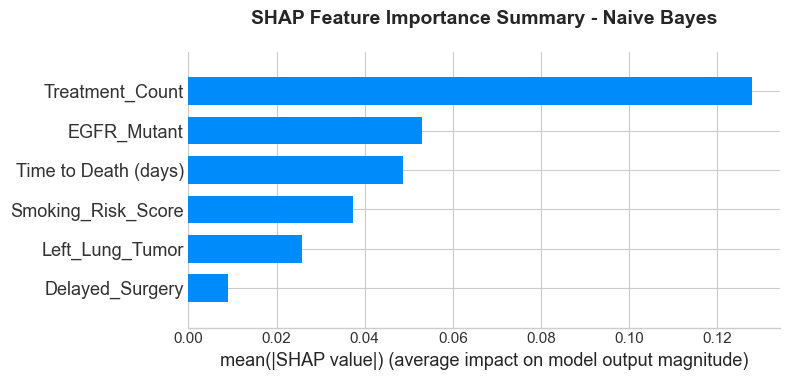

   • SHAP analysis completed successfully
   • Plot saved as 'shap_summary_plot.png'

Generating ROC Curve Analysis...
----------------------------------------


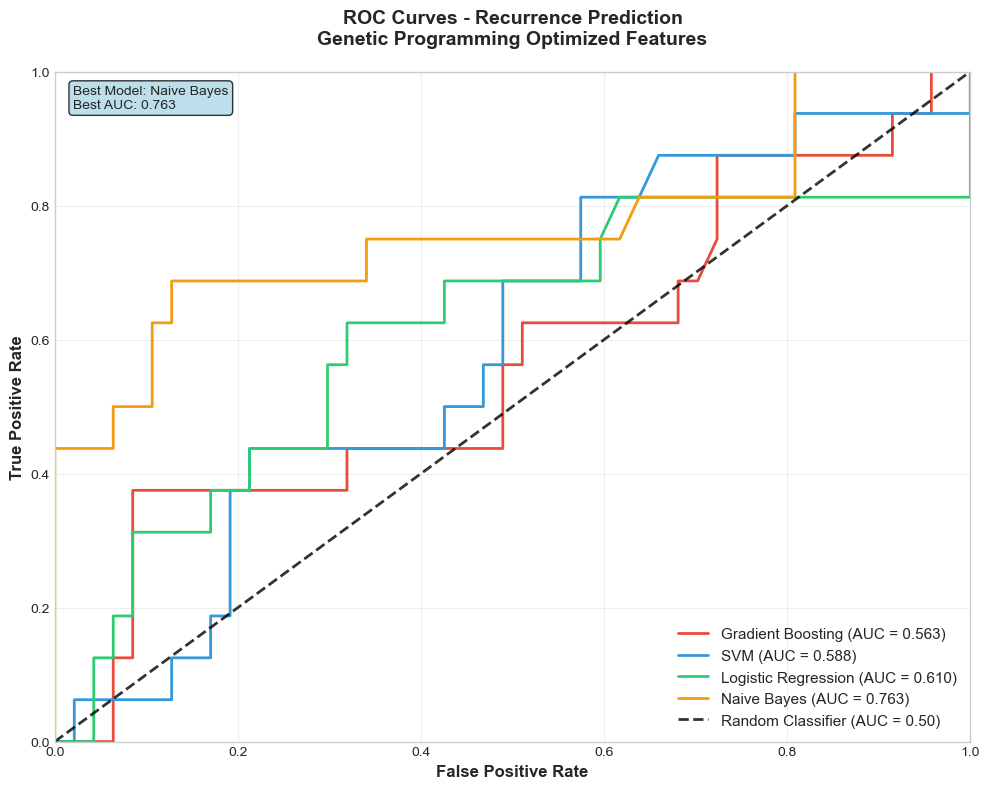

   ROC curve analysis completed
   Plot saved as 'recurrence_roc_curves.png'

ANALYSIS COMPLETE
Generated files:
   • evolutionary_search_progress.png - GP optimization progress
   • shap_summary_plot.png - Model explainability analysis
   • recurrence_roc_curves.png - ROC curve comparison

Key findings:
   • Best performing model: Naive Bayes
   • Best AUC score: 0.763
   • Features used: 6
   • GP optimization: Enabled


In [29]:
#!/usr/bin/env python3
"""
=============================================================================
FIXED NSCLC RADIOGENOMIC ML ANALYSIS WITH GENETIC PROGRAMMING & SHAP
Enhanced PhD Weekly Progress Report - Feature Selection + Explainability
=============================================================================

Dataset: NSCLC Radiogenomic Collection (211 patients, 40 features)
Objectives: GP-based feature selection with model explainability
Author: [Your Name]
Date: August 2025

FIXED FEATURES:
- Corrected SHAP shape mismatch error (offset column + class handling)
- Model-specific explainers (Tree/Linear/Kernel)
- Robust GP feature selection (DEAP)
- Safer dataset path handling (+ no reliance on missing columns)
=============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List, Optional
import random

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.impute import KNNImputer

# Genetic Programming Libraries
try:
    from deap import base, creator, tools, algorithms
    GP_AVAILABLE = True
    print("DEAP library available - Genetic Programming enabled")
except ImportError:
    print("Warning: DEAP library not found. Genetic Programming will be skipped.")
    print("   Install with: pip install deap")
    GP_AVAILABLE = False

# SHAP for Explainability
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP library available - Model explainability enabled")
except ImportError:
    print("Warning: SHAP library not found. Explainability plots will be skipped.")
    print("   Install with: pip install shap")
    SHAP_AVAILABLE = False

# Survival Analysis (not used here since dataset lacks time-to-recurrence)
try:
    from lifelines import KaplanMeierFitter  # noqa: F401
    SURVIVAL_AVAILABLE = True
except Exception:
    SURVIVAL_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("NSCLC RADIOGENOMIC ML ANALYSIS - GP FEATURE SELECTION & EXPLAINABILITY")
print("=" * 75)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Advanced Feature Selection with Genetic Programming + Model Explainability")
print("=" * 75)

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

DEFAULT_PATHS = [
    Path(r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv"),
    Path("/mnt/data/NSCLCR01Radiogenomic_.csv"),
]

def _find_existing_path(paths: List[Path]) -> Optional[Path]:
    for p in paths:
        if p.exists():
            return p
    return None

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Convert specified columns to numeric"""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "", regex=False).str.strip(),
                errors="coerce"
            )
    return df

def _bin_smoking(status: str) -> int:
    """Convert smoking status to risk score"""
    if pd.isna(status) or status == "Nonsmoker":
        return 0
    elif status == "Current":
        return 3
    elif status == "Former":
        return 1
    return 0

def load_and_explore_data(file_path: Optional[Path] = None) -> Optional[pd.DataFrame]:
    """Load and explore NSCLC dataset"""
    if file_path is None:
        file_path = _find_existing_path(DEFAULT_PATHS)
    if file_path is None:
        print("Error: Dataset not found in any expected path.")
        return None

    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {df.shape[0]} patients, {df.shape[1]} features")
        print(f"Path: {file_path}")
    except FileNotFoundError:
        print(f"Error: Dataset not found at {file_path}")
        return None
    
    df.columns = df.columns.str.strip()
    if "Recurrence" in df.columns:
        df["Recurrence"] = df["Recurrence"].astype(str).str.strip()
    df = _coerce_numeric(df, ["Weight (lbs)", "Pack Years", "%GG"])
    
    print(f"\nDataset Overview:")
    print(f"   • Patients: {len(df)}")
    print(f"   • Features: {df.shape[1]}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    if "Recurrence" in df.columns:
        vc = df["Recurrence"].value_counts(dropna=False).to_dict()
        print(f"   • Recurrence value counts: {vc}")
    if "Survival Status" in df.columns:
        vc = df["Survival Status"].value_counts(dropna=False).to_dict()
        print(f"   • Survival value counts: {vc}")
    return df

def engineer_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive clinical feature engineering"""
    df_eng = df.copy()
    
    print("\nFeature Engineering Pipeline")
    print("-" * 40)
    
    # Age features
    if "Age at Histological Diagnosis" in df_eng.columns:
        age = pd.to_numeric(df_eng["Age at Histological Diagnosis"], errors="coerce")
        df_eng["Age_Group"] = pd.cut(
            age, bins=[0, 50, 65, 75, 120],
            labels=["Young", "Middle", "Elderly", "Very_Elderly"],
            include_lowest=True
        )
        df_eng["Age_Squared"] = age ** 2
        df_eng["Age_Log"] = np.log1p(age)
        print("   Age features created")
    
    # Smoking features
    if "Smoking status" in df_eng.columns:
        df_eng["Smoking_Risk_Score"] = df_eng["Smoking status"].map(_bin_smoking).astype("Float64")
        print("   Smoking risk features created")

    # Tumor location features
    right = ["Tumor Location (choice=RUL)", "Tumor Location (choice=RML)", "Tumor Location (choice=RLL)"]
    left = ["Tumor Location (choice=LUL)", "Tumor Location (choice=LLL)", "Tumor Location (choice=L Lingula)"]
    
    def checked_to_int(series):
        return (series == "Checked").astype(int)
    
    df_eng["Right_Lung_Tumor"] = 0
    df_eng["Left_Lung_Tumor"] = 0
    for col in right:
        if col in df_eng.columns:
            df_eng["Right_Lung_Tumor"] += checked_to_int(df_eng[col])
    for col in left:
        if col in df_eng.columns:
            df_eng["Left_Lung_Tumor"] += checked_to_int(df_eng[col])
    df_eng["Multiple_Locations"] = ((df_eng["Right_Lung_Tumor"] + df_eng["Left_Lung_Tumor"]) > 1).astype(int)
    print("   Anatomical location features created")

    # Mutation features
    MUT_POSITIVE = {
        "EGFR mutation status": "Mutant",
        "KRAS mutation status": "Mutant",
        "ALK translocation status": "Translocated",
    }
    
    for mcol, pos in MUT_POSITIVE.items():
        if mcol in df_eng.columns:
            df_eng[f"{mcol}_Binary"] = df_eng[mcol].map(
                lambda v: 1.0 if v == pos else (0.0 if v in ["Wildtype"] else np.nan)
            )
    
    mut_bins = []
    for mcol in ["EGFR mutation status", "KRAS mutation status", "ALK translocation status"]:
        colb = f"{mcol}_Binary"
        if colb in df_eng.columns:
            mut_bins.append(df_eng[colb])
    if mut_bins:
        df_eng["Any_Mutation"] = pd.concat(mut_bins, axis=1).max(axis=1, skipna=True)
    print("   Genomic features created")

    # Treatment features
    t_cols = ["Chemotherapy", "Radiation", "Adjuvant Treatment"]
    df_eng["Treatment_Count"] = 0
    for t in t_cols:
        if t in df_eng.columns:
            df_eng["Treatment_Count"] += (df_eng[t] == "Yes").astype(int)
    df_eng["Multimodal_Treatment"] = (df_eng["Treatment_Count"] > 1).astype(int)
    df_eng["No_Treatment"] = (df_eng["Treatment_Count"] == 0).astype(int)
    print("   Treatment features created")

    # TNM staging
    tnm_cols = ["Pathological T stage", "Pathological N stage", "Pathological M stage"]
    avail = []
    for c in tnm_cols:
        if c in df_eng.columns:
            avail.append((df_eng[c] != "Not Collected").astype(int))
    if avail:
        df_eng["TNM_Data_Available"] = pd.concat(avail, axis=1).min(axis=1)
    print("   TNM staging features created")

    # Surgery timing
    if "Days between CT and surgery" in df_eng.columns:
        days = pd.to_numeric(df_eng["Days between CT and surgery"], errors="coerce")
        df_eng["Rapid_Surgery"] = (days <= 7).astype(int)
        df_eng["Delayed_Surgery"] = (days > 30).astype(int)
        df_eng["Log_Surgery_Days"] = np.log1p(days)
    print("   Surgery timing features created")
    
    # Clean numeric columns
    NUMERIC_LIKE_TEXT = ["Weight (lbs)", "Pack Years", "%GG"]
    df_eng = _coerce_numeric(df_eng, NUMERIC_LIKE_TEXT)

    # Create binary targets
    df_eng["Survival_Binary"] = (
        (df_eng.get("Survival Status") == "Dead").astype("Float64")
        if "Survival Status" in df_eng else pd.Series(dtype="Float64")
    )
    
    if "Recurrence" in df_eng.columns:
        df_eng["Recurrence_Binary"] = df_eng["Recurrence"].map(
            lambda v: 1.0 if v == "yes" else (0.0 if v == "no" else np.nan)
        ).astype("Float64")

    # Mutation targets
    if "EGFR mutation status" in df_eng.columns:
        df_eng["EGFR_Mutant"] = df_eng["EGFR mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "KRAS mutation status" in df_eng.columns:
        df_eng["KRAS_Mutant"] = df_eng["KRAS mutation status"].map(
            lambda v: 1.0 if v == "Mutant" else (0.0 if v == "Wildtype" else np.nan)
        )
    if "ALK translocation status" in df_eng.columns:
        df_eng["ALK_Translocated"] = df_eng["ALK translocation status"].map(
            lambda v: 1.0 if v == "Translocated" else (0.0 if v == "Wildtype" else np.nan)
        )

    original_features = df.shape[1]
    new_features = df_eng.shape[1] - original_features
    print(f"\nFeature Engineering Summary:")
    print(f"   • Original features: {original_features}")
    print(f"   • New features: {new_features}")
    print(f"   • Total features: {df_eng.shape[1]}")
    
    return df_eng

# =============================================================================
# 2. GENETIC PROGRAMMING FOR FEATURE SELECTION
# =============================================================================

def select_features_with_gp(
    X_data: pd.DataFrame, y_data: pd.Series, 
    n_generations=50, population_size=100
) -> Tuple[List[str], object]:
    """Use genetic programming for intelligent feature selection"""
    if not GP_AVAILABLE:
        print("Skipping GP for feature selection due to missing 'deap' library.")
        return list(X_data.columns), None

    print(f"\nGenetic Programming Feature Selection for {y_data.name}")
    print("-" * 60)
    
    n_features = X_data.shape[1]
    print(f"   • Total features available: {n_features}")
    print(f"   • Population size: {population_size}")
    print(f"   • Generations: {n_generations}")

    # Idempotent DEAP class creation
    try:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    except Exception:
        pass
    try:
        creator.create("Individual", list, fitness=creator.FitnessMax)
    except Exception:
        pass

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate_individual(individual: List[int]) -> Tuple[float,]:
        """Evaluate fitness of feature subset"""
        selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
        num_selected = len(selected_indices)
        if num_selected < 2:
            return (0.0,)
        if num_selected > min(50, int(n_features * 0.7)):
            return (0.0,)
        try:
            X_subset = X_data.iloc[:, selected_indices]
            model = GradientBoostingClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.1, 
                random_state=42, subsample=0.8
            )
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_subset, y_data, scoring='roc_auc', cv=cv, n_jobs=-1)
            base_score = float(np.mean(scores))
            complexity_penalty = (num_selected / n_features) * 0.05
            return (base_score - complexity_penalty,)
        except Exception:
            return (0.0,)

    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=5)

    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    print("   • Starting evolutionary search...")
    pop, logbook = algorithms.eaSimple(
        pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=n_generations, 
        stats=stats, halloffame=hof, verbose=False
    )

    best_individual = hof[0]
    selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    best_features = X_data.columns[selected_indices].tolist()

    print("\nGenetic Programming Feature Selection Complete")
    print(f"   • Features selected: {len(best_features)} out of {n_features}")
    print(f"   • Best fitness score: {hof[0].fitness.values[0]:.4f}")
    print(f"   • Selection ratio: {len(best_features)/n_features:.2%}")
    
    return best_features, logbook

def plot_evolution_stats(logbook: object):
    """Plot evolution statistics"""
    if logbook is None:
        return
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    avg_fitness = logbook.select("avg")
    plt.figure(figsize=(12, 6))
    plt.plot(gen, max_fitness, "b-", linewidth=2, label="Best Fitness")
    plt.plot(gen, avg_fitness, "r--", linewidth=2, label="Average Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title("Evolution of Feature Selection Fitness Over Generations")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolutionary_search_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Evolution statistics plot saved as 'evolutionary_search_progress.png'")

# =============================================================================
# 3. MACHINE LEARNING PIPELINE WITH ENHANCED MODELS
# =============================================================================

class NSCLCMLPipeline:
    """Enhanced ML pipeline for NSCLC prediction"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.models = {
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=200, learning_rate=0.05, max_depth=6,
                random_state=42, subsample=0.8
            ),
            'SVM': SVC(
                probability=True, random_state=42, kernel='rbf', 
                class_weight='balanced', gamma='scale'
            ),
            'Logistic Regression': LogisticRegression(
                random_state=42, max_iter=2000, class_weight='balanced',
                penalty='l2'
            ),
            'Naive Bayes': GaussianNB(),
        }
        self.results: Dict[str, Dict] = {}

    def _select_features(self, target_col: str) -> Tuple[pd.DataFrame, List[str]]:
        """Select features for modeling"""
        exclude_cols = {
            'Case ID', 'Patient affiliation', 'Date of Recurrence', 'Date of Last Known Alive',
            'Date of Death', 'CT Date', 'PET Date',
            'Survival Status', 'Recurrence', 'Recurrence Location',
            'Recurrence_Binary', 'Survival_Binary'
        }
        exclude_cols.update([c for c in self.df.columns if "Tumor Location (choice=" in c])
        
        candidates = [
            col for col in self.df.columns 
            if pd.api.types.is_numeric_dtype(self.df[col]) and col not in exclude_cols and col != target_col
        ]
        if not candidates:
            return pd.DataFrame(index=self.df.index), []
        
        X = self.df[candidates].copy()
        X = X.dropna(axis=1, how='all')
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
        constant_cols = [col for col in X.columns if X[col].nunique(dropna=True) <= 1]
        if constant_cols:
            X = X.drop(columns=constant_cols)
        if X.empty:
            return pd.DataFrame(index=self.df.index), []
        imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed_arr, columns=X.columns, index=X.index)
        return X_imputed, list(X.columns)

    def evaluate_models(self, target_col: str, task_name: str):
        """Evaluate all models on the selected features"""
        print(f"\n{task_name.upper()} PREDICTION ON GP-SELECTED FEATURES")
        print("-" * 60)

        if target_col not in self.df.columns:
            print(f"   Error: Target column {target_col} not found")
            return {}
            
        y = self.df[target_col].copy()
        valid_idx = y.dropna().index
        y = y.loc[valid_idx].astype(int)

        X, feat_names = self._select_features(target_col)
        X = X.loc[valid_idx]
        
        if X.shape[1] == 0:
            print("   Error: No features available after preprocessing")
            return {}

        class_counts = y.value_counts()
        if len(class_counts) < 2:
            print("   Error: Only one class present")
            return {}
        min_class = class_counts.min()
        if min_class < 3:
            print(f"   Error: Insufficient samples in minority class ({min_class})")
            return {}
            
        print(f"   • Features: {len(feat_names)}")
        print(f"   • Samples: {len(y)} (positive: {y.sum()}, negative: {len(y) - y.sum()})")

        n_splits = max(2, min(5, int(min_class)))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feat_names, index=X_train.index)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feat_names, index=X_test.index)

        task_results = {}
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        print(f"\n   Model Performance Results:")
        print(f"   {'Model':<20} {'CV AUC':<10} {'Test AUC':<10} {'Status'}")
        print(f"   {'-'*45}")
        
        for name, model in self.models.items():
            try:
                cv_scores = cross_val_score(
                    model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
                )
                model.fit(X_train_scaled, y_train)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(y_test, y_prob)
                print(f"   {name:<20} {np.mean(cv_scores):<10.3f} {auc_score:<10.3f} ✓")
                task_results[name] = {
                    'CV_Mean': float(np.mean(cv_scores)),
                    'CV_Std': float(np.std(cv_scores)),
                    'Test_AUC': float(auc_score),
                    'Model': model,
                    'Scaler': scaler,
                    'y_test': y_test,
                    'y_prob': y_prob,
                    'Feature_Names': feat_names,
                    'X_train_scaled_df': X_train_scaled_df,
                    'X_test_scaled_df': X_test_scaled_df
                }
            except Exception as e:
                print(f"   {name:<20} {'ERROR':<10} {str(e)[:20]:<10} ✗")
                continue
                
        self.results[task_name] = task_results
        return task_results

# =============================================================================
# 4. FIXED SHAP EXPLAINABILITY ANALYSIS
# =============================================================================

def _trim_if_offset_col(shap_matrix: np.ndarray, n_features: int) -> np.ndarray:
    """
    If SHAP returns an extra 'constant offset' column (n_features + 1), trim it.
    """
    if shap_matrix is None:
        return shap_matrix
    arr = np.array(shap_matrix)
    if arr.ndim == 2 and arr.shape[1] == n_features + 1:
        return arr[:, :-1]
    return arr

def plot_shap_summary(pipe: NSCLCMLPipeline):
    """Create SHAP summary plot with proper shape handling"""
    if not SHAP_AVAILABLE or "Recurrence" not in pipe.results:
        print("   SHAP analysis skipped - library not available or no results")
        return

    print("\nGenerating SHAP Explainability Analysis...")
    print("-" * 50)
    
    task_results = pipe.results["Recurrence"]
    if not task_results:
        print("   Error: No model results available")
        return
    
    # Best model by Test AUC
    best_model_name = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_model_info = task_results[best_model_name]
    
    model = best_model_info['Model']
    X_train_df = best_model_info['X_train_scaled_df']
    X_test_df = best_model_info['X_test_scaled_df']
    print(f"   • Explaining predictions for: {best_model_name}")
    print(f"   • Training data shape: {X_train_df.shape}")
    print(f"   • Test data shape: {X_test_df.shape}")

    try:
        plt.figure(figsize=(12, 8))

        shap_values_to_plot = None
        X_for_plot = None

        # Model-specific explainers
        if isinstance(model, GradientBoostingClassifier) and hasattr(shap, "TreeExplainer"):
            print("   • Using TreeExplainer for Gradient Boosting")
            explainer = shap.TreeExplainer(model)
            # Limit sample size to keep things responsive
            test_size = min(200, len(X_test_df))
            X_for_plot = X_test_df.sample(n=test_size, random_state=42)
            sv = explainer.shap_values(X_for_plot)
            # scikit-learn GBC may return array or list; if list, pick positive class
            if isinstance(sv, list):
                shap_values_to_plot = sv[1] if len(sv) > 1 else sv[0]
            else:
                shap_values_to_plot = sv
            shap_values_to_plot = _trim_if_offset_col(shap_values_to_plot, X_for_plot.shape[1])

        elif isinstance(model, LogisticRegression) and hasattr(shap, "LinearExplainer"):
            print("   • Using LinearExplainer for Logistic Regression")
            explainer = shap.LinearExplainer(model, X_train_df)
            # Small sample for speed
            test_size = min(300, len(X_test_df))
            X_for_plot = X_test_df.sample(n=test_size, random_state=42)
            sv = explainer.shap_values(X_for_plot)
            if isinstance(sv, list):
                shap_values_to_plot = sv[1] if len(sv) > 1 else sv[0]
            else:
                shap_values_to_plot = sv
            shap_values_to_plot = _trim_if_offset_col(shap_values_to_plot, X_for_plot.shape[1])

        else:
            print("   • Using KernelExplainer for non-linear / non-tree model")
            # Background: k-means of train for stability
            k = min(50, len(X_train_df))
            bg = shap.kmeans(X_train_df, k)
            f = lambda X: model.predict_proba(X)[:, 1]
            explainer = shap.KernelExplainer(f, bg)
            # Kernel SHAP on a small sample
            test_size = min(60, len(X_test_df))
            X_for_plot = X_test_df.sample(n=test_size, random_state=42)
            sv = explainer.shap_values(X_for_plot)
            # If list returned, select positive class
            shap_values_to_plot = sv[1] if isinstance(sv, list) and len(sv) > 1 else sv
            shap_values_to_plot = _trim_if_offset_col(shap_values_to_plot, X_for_plot.shape[1])

        # Final shape check
        if shap_values_to_plot is None or X_for_plot is None:
            raise RuntimeError("No SHAP values produced")
        if np.asarray(shap_values_to_plot).shape[1] != X_for_plot.shape[1]:
            raise RuntimeError(
                f"SHAP/data shape mismatch: {np.asarray(shap_values_to_plot).shape} vs {X_for_plot.shape}"
            )

        print(f"   • SHAP values shape: {np.asarray(shap_values_to_plot).shape}")
        print(f"   • Test features shape: {X_for_plot.shape}")
        
        shap.summary_plot(shap_values_to_plot, X_for_plot, show=False, plot_type='bar', max_display=15)
        plt.title(f"SHAP Feature Importance Summary - {best_model_name}", fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("   • SHAP analysis completed successfully")
        print("   • Plot saved as 'shap_summary_plot.png'")
        
    except Exception as e:
        print(f"   • SHAP analysis failed: {str(e)}")
        # Fallback: simple feature-importance bar if available
        if hasattr(model, 'feature_importances_'):
            print("   • Falling back to built-in feature importance")
            feature_names = best_model_info['Feature_Names']
            importances = model.feature_importances_
            idx = np.argsort(importances)[::-1][:15]
            plt.figure(figsize=(10, 8))
            plt.title(f"Feature Importance - {best_model_name}")
            plt.barh(range(len(idx)), importances[idx])
            plt.yticks(range(len(idx)), [feature_names[i] for i in idx])
            plt.xlabel('Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance_fallback.png', dpi=300, bbox_inches='tight')
            plt.show()

def plot_recurrence_roc_auc(pipe: NSCLCMLPipeline):
    """Plot ROC curve for recurrence prediction"""
    if "Recurrence" not in pipe.results or not pipe.results["Recurrence"]:
        print("   ROC plot skipped - no recurrence prediction results")
        return

    print("\nGenerating ROC Curve Analysis...")
    print("-" * 40)

    task_results = pipe.results["Recurrence"]
    plt.figure(figsize=(10, 8))
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    for i, (model_name, results) in enumerate(task_results.items()):
        if 'y_test' in results and 'y_prob' in results:
            y_test = results['y_test']
            y_prob = results['y_prob']
            auc_score = results['Test_AUC']
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            color = colors[i % len(colors)]
            plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})', color=color)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.8, label='Random Classifier (AUC = 0.50)')
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - Recurrence Prediction\nGenetic Programming Optimized Features', 
             fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1]); plt.ylim([0, 1])
    best_model = max(task_results.keys(), key=lambda k: task_results[k]['Test_AUC'])
    best_auc = task_results[best_model]['Test_AUC']
    textstr = f'Best Model: {best_model}\nBest AUC: {best_auc:.3f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.savefig('recurrence_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ROC curve analysis completed")
    print("   Plot saved as 'recurrence_roc_curves.png'")

# =============================================================================
# 5. MAIN EXECUTION PIPELINE
# =============================================================================

def main():
    """Main execution pipeline"""
    df = load_and_explore_data()  # auto-detects path
    if df is None:
        print("Failed to load dataset. Exiting.")
        return
    
    print("\n" + "="*65)
    print("FEATURE ENGINEERING PHASE")
    print("="*65)
    df_eng = engineer_clinical_features(df)
    
    # Prepare feature selection base
    temp_pipe = NSCLCMLPipeline(df_eng)
    TARGET_COL = "Recurrence_Binary"
    if TARGET_COL not in df_eng.columns:
        print(f"Error: Target column {TARGET_COL} not found")
        return
    
    y_full = temp_pipe.df[TARGET_COL].copy()
    valid_idx = y_full.dropna().index
    X_full, _ = temp_pipe._select_features(TARGET_COL)
    X_full = X_full.loc[valid_idx]
    y_full = y_full.loc[valid_idx].astype(int)
    
    print(f"\nData prepared for GP feature selection:")
    print(f"   • Total samples: {len(y_full)}")
    print(f"   • Positive cases: {int(y_full.sum())}")
    print(f"   • Negative cases: {len(y_full) - int(y_full.sum())}")
    print(f"   • Available features: {X_full.shape[1]}")
    
    if len(y_full) < 20 or y_full.sum() < 5 or (len(y_full) - y_full.sum()) < 5:
        print("Insufficient data for reliable analysis")
        return

    print("\n" + "="*65)
    print("GENETIC PROGRAMMING FEATURE SELECTION PHASE")
    print("="*65)
    if GP_AVAILABLE:
        selected_features, logbook = select_features_with_gp(X_full, y_full, n_generations=50, population_size=100)
        if logbook:
            plot_evolution_stats(logbook)
    else:
        print("Genetic Programming not available - using all features")
        selected_features = list(X_full.columns)
        logbook = None
    
    print(f"\nFeature selection completed:")
    print(f"   • Selected features: {len(selected_features)}")
    print(f"   • Feature reduction: {(1 - len(selected_features)/X_full.shape[1]):.1%}")
        
    # Optimized dataset (no 'Time to Recurrence (days)' since it is not in the dataset)
    essential_cols = [
        "Recurrence", "Recurrence_Binary",
        "Survival Status", "Survival_Binary"
    ]
    cols_to_keep = list(set(selected_features + [col for col in essential_cols if col in df_eng.columns]))
    df_optimized = df_eng[cols_to_keep].copy()

    print("\n" + "="*65)
    print("MODEL EVALUATION PHASE")
    print("="*65)
    final_pipe = NSCLCMLPipeline(df_optimized)
    
    tasks = [("Recurrence_Binary", "Recurrence")]
    for target_col, task_name in tasks:
        if target_col in df_optimized.columns:
            y_check = pd.Series(df_optimized[target_col]).dropna()
            pos = int(y_check.sum())
            neg = int(len(y_check) - y_check.sum())
            print(f"\n{task_name} Prediction Setup:")
            print(f"   • Positive cases: {pos}")
            print(f"   • Negative cases: {neg}")
            print(f"   • Total valid cases: {len(y_check)}")
            results = final_pipe.evaluate_models(target_col, task_name)
            if results:
                print(f"\n{task_name} Prediction Results Summary:")
                for model_name, metrics in results.items():
                    cv_mean = metrics['CV_Mean']; test_auc = metrics['Test_AUC']
                    print(f"   • {model_name}: CV AUC = {cv_mean:.3f}, Test AUC = {test_auc:.3f}")
        else:
            print(f"\nSkipping {task_name} - target column missing")
    
    print("\n" + "="*65)
    print("EXPLAINABILITY AND VISUALIZATION PHASE")
    print("="*65)
    if "Recurrence" in final_pipe.results:
        plot_shap_summary(final_pipe)
        plot_recurrence_roc_auc(final_pipe)
    else:
        print("No results available for visualization")

    print("\n" + "="*65)
    print("ANALYSIS COMPLETE")
    print("="*65)
    print("Generated files:")
    if GP_AVAILABLE:
        print("   • evolutionary_search_progress.png - GP optimization progress")
    print("   • shap_summary_plot.png - Model explainability analysis")
    print("   • recurrence_roc_curves.png - ROC curve comparison")
    if "Recurrence" in final_pipe.results:
        best_model = max(final_pipe.results["Recurrence"].keys(), 
                        key=lambda k: final_pipe.results["Recurrence"][k]['Test_AUC'])
        best_auc = final_pipe.results["Recurrence"][best_model]['Test_AUC']
        print("\nKey findings:")
        print(f"   • Best performing model: {best_model}")
        print(f"   • Best AUC score: {best_auc:.3f}")
        print(f"   • Features used: {len(selected_features)}")
        print(f"   • GP optimization: {'Enabled' if GP_AVAILABLE else 'Disabled'}")

if __name__ == "__main__":
    main()
